# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Цель исследования:

  1) Определить влияние различных факторов на ценообразование объектов.\
  2) Изучить скорость продажи объектов.\
  3) Составить топ-10 населённых пунктов с наибольшим количеством предложений.\
  4) Изучить ценообразование в черте Санкт-Петербурга.
  
   #### Ход исследования:
  
   Данные получим из файла /datasets/real_estate_data.csv. О качестве данных ничего не известно, поэтому необходимо будет тщательно изучить их.
   
   На этапе предобработки данных найдём все пропущенные значения, обработаем их, удалим явные выбросы, избавимся от дубликатов. После этого создадим новые столбцы, необходимые для анализа данных, и начнём достигать цели исследования.
   
   Таким образом, работа состоит из следующих этапов:
   
   - обзор полученных данных;
   - предобработка данных;
   - добавление необходимой информации в таблицу;
   - проведение анализа по конкретным столбцам;
   - изучение скорости продажи объектов;
   - изучение факторов ценообразования;
   - составление топ-10 населённых пунктов по количеству объявлений;
   - изучение ценообразования в черте Санкт-Петербурга;
   - написание общего вывода.

### Откройте файл с данными и изучите общую информацию. 

In [1]:
#Откроем файл и изучим его. При первом открытии видно, что строки и столбцы поделены знаком табуляции, поэтому добавим 'sep'
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
print(data.head())

   total_images  last_price  total_area first_day_exposition  rooms  \
0            20  13000000.0       108.0  2019-03-07T00:00:00      3   
1             7   3350000.0        40.4  2018-12-04T00:00:00      1   
2            10   5196000.0        56.0  2015-08-20T00:00:00      2   
3             0  64900000.0       159.0  2015-07-24T00:00:00      3   
4             2  10000000.0       100.0  2018-06-19T00:00:00      2   

   ceiling_height  floors_total  living_area  floor is_apartment  ...  \
0            2.70          16.0         51.0      8          NaN  ...   
1             NaN          11.0         18.6      1          NaN  ...   
2             NaN           5.0         34.3      4          NaN  ...   
3             NaN          14.0          NaN      9          NaN  ...   
4            3.03          14.0         32.0     13          NaN  ...   

   kitchen_area  balcony    locality_name  airports_nearest  \
0          25.0      NaN  Санкт-Петербург           18863.0   
1       

In [2]:
#Выведем общую информцаю по столбцам
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

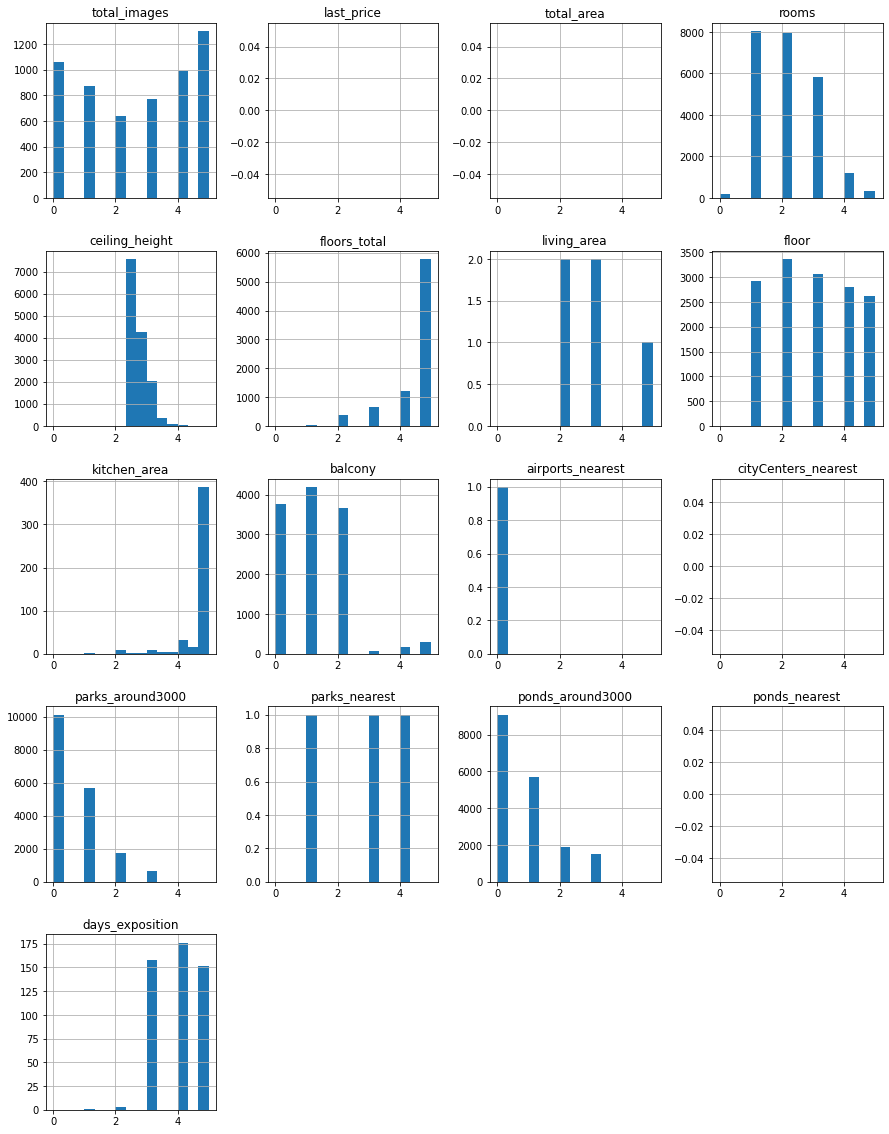

In [3]:
#Построим гистограммы по исходным данным, возьмём маленький разброс данных, чтобы визуально увидеть нулевые значения по каждому столбцу
data.hist(bins=15, range=(0, 5), figsize=(15, 20))
plt.show()

#### Вывод: 
Изучив общую информацию, можно сказать о следующем: большинство столбцов содержат пропуски, которые нужно будет обработать (максимальное количество пропусков в столбце "is_apartment"); в 6 столбцах наблюдаются нулевые значения, чтобы понять причину этого, нужно анализировать каждый столбец отдельно (например, 0 комнат в квартире или 0 расстояние до аэропорта вылядят как явные ошибки, в то время как 0 балконов в квартире вполне реальная ситуация).

### Предобработка данных

In [4]:
#Для упрощения сравнения результатов "до" и "после" предобработки выведем количество пропусков по каждому столбцу в начальной таблице.
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

In [5]:
pd.DataFrame(round(data.isna().mean()*100,)).style.background_gradient('coolwarm')

,0
total_images,0.000000
last_price,0.000000
total_area,0.000000
first_day_exposition,0.000000
rooms,0.000000
ceiling_height,39.000000
floors_total,0.000000
living_area,8.000000
floor,0.000000
is_apartment,88.000000


Из предыдущего пункта мы знаем, в каких столбцах пропущены значения. начнём обрабатывать их по порядку. Первый на очереди столбец "ceiling_height" - "высота потолков". 

In [6]:
#Посчитаем среднее и медиану по известным значениям и посмотрим, можем ли мы заменить пропуски на конкретную цифру.
print(data['ceiling_height'].mean())
print(data['ceiling_height'].median())

2.77149889685604
2.65


Как видим, показатели различаются незначительно, значит, замена пропусков на медианное значение некритично скажется на данных.

In [7]:
#Замена на медианные значения:
data['ceiling_height'] = data['ceiling_height'].fillna(data['ceiling_height'].median())
print(data['ceiling_height'].isna().sum())

0


Следующий столбец "floors_total" - "всего этажей в доме". Здесь уже подстановка среднего или медианного значений не подойдёт. Возможно, пропуски стоят в предложениях по одноэтажным домам; чтобы это проверить, посмотрим уникальные значения столбца.

In [8]:
#Уникальные значения столбца.
print(data['floors_total'].value_counts().sort_values(ascending=False))
print(data['floors_total'].unique())

5.0     5788
9.0     3761
16.0    1376
12.0    1362
4.0     1200
10.0    1174
25.0    1075
6.0      914
17.0     833
3.0      668
7.0      592
14.0     553
18.0     505
24.0     469
8.0      390
2.0      383
15.0     365
23.0     352
19.0     339
22.0     286
20.0     271
13.0     229
11.0     203
27.0     164
21.0     158
26.0     124
1.0       25
35.0      24
28.0      21
36.0       3
37.0       1
34.0       1
33.0       1
60.0       1
29.0       1
52.0       1
Name: floors_total, dtype: int64
[16. 11.  5. 14. 12. 26. 24. 27.  9.  6. 17. 25.  3. 23. 19. 18.  4. 22.
  8.  2. 10.  7. 13. 15. nan 20. 28. 36. 21. 35. 34. 60.  1. 29. 33. 52.
 37.]


Определить конкретно, сколько этажей в домах, не представляется возможным. Гипотеза о том, что это все одноэтажные дома не подтвердилась. Так как их количество менее 1% от общей выборки, мы можем удалить строки с пропусками без особого ущерба.

In [9]:
#Удаляем пропуски:
data = data.dropna(subset=['floors_total'])

Следующий столбец "living_area" - "жилая площадь". Данные из этого столбца очень важны, однако, как и с предыдущим столбцом, установить точное значение для каждого невозможно. 8% от общего количества, конечно, достаточно много, посмотрим некоторые примеры таких объектов.

In [10]:
data['living_area'] = data['living_area'].fillna(0)
print(data[data['living_area']==0]['living_area'].count())
print(data[data['living_area']==0].head(10))

1870
     total_images  last_price  total_area first_day_exposition  rooms  \
3               0  64900000.0       159.0  2015-07-24T00:00:00      3   
7               5   7915000.0        71.6  2019-04-18T00:00:00      2   
30             12   2200000.0        32.8  2018-02-19T00:00:00      1   
37             10   1990000.0        45.8  2017-10-28T00:00:00      2   
44             13   5350000.0        40.0  2018-11-18T00:00:00      1   
59             15   6300000.0        46.5  2017-03-06T00:00:00      1   
60              3   2740000.0        35.0  2018-01-01T00:00:00      1   
81              9  10949000.0        68.0  2018-12-27T00:00:00      1   
82              3   4500000.0        80.5  2018-01-15T00:00:00      3   
116            18  10999000.0        97.2  2017-11-13T00:00:00      3   

     ceiling_height  floors_total  living_area  floor is_apartment  ...  \
3              2.65          14.0          0.0      9          NaN  ...   
7              2.65          24.0        

Видно, что пропусков в этих строчках достаточно много. Можем предположить, что жилая площадь примерно равна разности общей и кухонной, поэтому заменяем все пропуски в 'kitchen_area' на 0 и обрабатываем то, что получится.

In [11]:
#Попытка заполнить пропуски в "living_area":
data['kitchen_area'] = data['kitchen_area'].fillna(0)
data[(data['living_area']==0)&(data['kitchen_area']!=0)] = data[data['living_area']==(data['total_area'] - data['kitchen_area'])]
print(data[data['living_area']==0]['living_area'].count())

1431


Сумели сохранить четверть пропущенных данных. Оставшуюся часть придётся удалить.

In [12]:
#Удаляем непоределённые данные
data = data[data['living_area']!=0]

"is_apartment" - "является ли помещение апартаментами". 

In [13]:
#посмотрим, какие значения указаны в данном столбце.
print(data['is_apartment'].unique())

[nan False True]


Изменим тип данных в этом столбце на булевые значения и посмотрим, что произойдёт с пропусками.

In [14]:
#Изменяем тип данных:
data['is_apartment'] = data['is_apartment'].astype('bool')
print(data['is_apartment'].isna().sum())

0


Оказалось, что всё дело в неправильном типе данных. Сам столбец пропусков не имеет.

"kitchen_area" - "площадь кухни". Ситуация схожа с жилой площадью. Посмотрим, сколько таких объектов осталось.

In [15]:
print(data[data['kitchen_area']==0]['kitchen_area'].count())

800


Мы уже удалили достаточно большой массив данных, эти 800 вариантов надо обработать. Логично предположить, что на кухню останется примерно разность общей и жилой площадей.

In [16]:
#Обработаем пропуски:
data[data['kitchen_area']==0] = data[data['kitchen_area']==(data['total_area'] - data['living_area'])]
print(data[data['kitchen_area']==0])

       total_images  last_price  total_area first_day_exposition  rooms  \
9861           10.0   2350000.0        25.0  2017-12-03T00:00:00    0.0   
12691           1.0   3700000.0        24.2  2017-11-10T00:00:00    0.0   

       ceiling_height  floors_total  living_area  floor is_apartment  ...  \
9861             2.65          22.0         25.0   17.0         True  ...   
12691            2.65          19.0         24.2   13.0         True  ...   

      kitchen_area balcony    locality_name  airports_nearest  \
9861           0.0     2.0   посёлок Мурино               NaN   
12691          0.0     1.0  Санкт-Петербург           17837.0   

      cityCenters_nearest  parks_around3000  parks_nearest  ponds_around3000  \
9861                  NaN               NaN            NaN               NaN   
12691             16840.0               0.0            NaN               2.0   

       ponds_nearest  days_exposition  
9861             NaN             13.0  
12691          210.0     

Осталось 2 варианта, где общая площадь равна жилой. В теории такое можно придумать, но в нашем анализе рассматриваются традиционные объекты, поэтому удалим эти 2 строки.

In [17]:
#"kitchen_area" удаляем пропуски.
data = data[data['kitchen_area']!=0]

"balcony" - "число балконов". Логично предположить, что на месте всех пропусков должно стоять число "0". Заменим их, а заодно изменим тип данных.

In [18]:
#Заменяем пропуски и обновляем тип данных:
data['balcony'] = data['balcony'].fillna(0)
data['balcony'] = data['balcony'].astype('int')

"locality_name" - "название населённого пункта". Пропуски в данном столбце критичны для последующего анализа. Так как их менее 1% от общей выборки, удалим строки с пропусками в нём.

In [19]:
#Удаляем пропуски
data = data.dropna(subset=['locality_name'])

Последующие столбцы "airports_nearest", "cityCenters_nearest", "parks_around3000", "parks_nearest", "ponds_around3000", "ponds_nearest" являются уточняющими, неосновными. Кроме этого, количество пропусков в них практически идентично. Интересно, связаны они друг с другом или нет?

In [20]:
#Проверка на незаполненные объявления:
print(data[
    (data['parks_nearest'] == 'NaN') & (data['ponds_nearest'] == 'NaN') &
    (data['parks_around3000'] == 'NaN') & (data['ponds_around3000'] == 'NaN')
]['last_price'].count())

0


Как видим, гипотеза не является истиной. Получается, во всех объявлениях люди отмечали правдивую информацию, а остальные пункты
#пропускали. В случае со столбцами "parks_around3000" и "ponds_around3000" достаточно заменить пропущенные значения на 0:

In [21]:
#Замена на 0:
data['ponds_around3000'] = data['ponds_around3000'].fillna(0)
data['parks_around3000'] = data['parks_around3000'].fillna(0)

В остальные 4 столбца попробуем подставить медианные значения. Позже посмотрим, насколько сильно это скажется на результатах.

In [22]:
#Замена на медианные значения:
data['airports_nearest'] = data['airports_nearest'].fillna(data['airports_nearest'].median())
data['cityCenters_nearest'] = data['cityCenters_nearest'].fillna(data['cityCenters_nearest'].median())
data['parks_nearest'] = data['parks_nearest'].fillna(data['parks_nearest'].median())
data['ponds_nearest'] = data['ponds_nearest'].fillna(data['ponds_nearest'].median())

Крайний столбец "days_exposition" - "срок размещения объявления" также очень важен для анализа. Так как никакого способа достоверно восстановить эти данные нет, придётся удалить, дабы сохранить точность исследования.

In [23]:
#Удаление пропусков:
data['days_exposition'] = data['days_exposition'].fillna(0)
data = data[data['days_exposition']!=0]

Проверим, не осталось ли больше пропусков:

In [24]:
#Проверим, все ли пропуски были ликвидированы:
print(data.isna().sum())

total_images            0
last_price              0
total_area              0
first_day_exposition    0
rooms                   0
ceiling_height          0
floors_total            0
living_area             0
floor                   0
is_apartment            0
studio                  0
open_plan               0
kitchen_area            0
balcony                 0
locality_name           0
airports_nearest        0
cityCenters_nearest     0
parks_around3000        0
parks_nearest           0
ponds_around3000        0
ponds_nearest           0
days_exposition         0
dtype: int64


Посмотрим на общую информацию по таблице.

In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18020 entries, 1 to 23695
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          18020 non-null  float64
 1   last_price            18020 non-null  float64
 2   total_area            18020 non-null  float64
 3   first_day_exposition  18020 non-null  object 
 4   rooms                 18020 non-null  float64
 5   ceiling_height        18020 non-null  float64
 6   floors_total          18020 non-null  float64
 7   living_area           18020 non-null  float64
 8   floor                 18020 non-null  float64
 9   is_apartment          18020 non-null  object 
 10  studio                18020 non-null  object 
 11  open_plan             18020 non-null  object 
 12  kitchen_area          18020 non-null  float64
 13  balcony               18020 non-null  int64  
 14  locality_name         18020 non-null  object 
 15  airports_nearest   

Видим, что чуть больше 20% данных было удалено, но в оставшихся мы теперь наверняка уверены. Также видим, что в некоторых столбцах послетали исходные типы данных. Вернём их, заодно изменим те, что были изначально не в том виде.

In [26]:
#Меняем типы данных в слетевших столбцах
data['total_images'] = data['total_images'].astype('int')
data['rooms'] = data['rooms'].astype('int')
data['floor'] = data['floor'].astype('int')
data['is_apartment'] = data['is_apartment'].astype('bool')
data['studio'] = data['studio'].astype('bool')
data['open_plan'] = data['open_plan'].astype('bool')
data['days_exposition'] = data['days_exposition'].astype('int')

#Изменим тип данных в столбцах "first_day_exposition" и "floors_total":
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')
data['floors_total'] = data['floors_total'].astype('int')
print(data['first_day_exposition'].head())

1   2018-12-04
2   2015-08-20
4   2018-06-19
5   2018-09-10
6   2017-11-02
Name: first_day_exposition, dtype: datetime64[ns]


In [27]:
#Убедимся в том, что всё прошло успешно:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18020 entries, 1 to 23695
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          18020 non-null  int64         
 1   last_price            18020 non-null  float64       
 2   total_area            18020 non-null  float64       
 3   first_day_exposition  18020 non-null  datetime64[ns]
 4   rooms                 18020 non-null  int64         
 5   ceiling_height        18020 non-null  float64       
 6   floors_total          18020 non-null  int64         
 7   living_area           18020 non-null  float64       
 8   floor                 18020 non-null  int64         
 9   is_apartment          18020 non-null  bool          
 10  studio                18020 non-null  bool          
 11  open_plan             18020 non-null  bool          
 12  kitchen_area          18020 non-null  float64       
 13  balcony         

Пропусков больше нет, переходим к другим аномалиям в данных. Ранее уже были построены гистограммы по количественным данным, в них наблюдаем 2 странности: небольшое количество квартир указано с 0 комнат, 1 c 0 расстоянием до аэропорта. Второе явно является ошибкой. Что касается первого, необходимо проверить, не обозначали ли так студии или апартаменты.

In [28]:
#Проверка на логику нулевых значений:
print(data[data['rooms']==0]['rooms'].count())
print(data[(data['studio']==True) & (data['rooms']==0)]['studio'].count())
print(data[(data['is_apartment']==True) & (data['rooms']==0)]['studio'].count())
print(data[(data['studio']==True) & (data['is_apartment']==True) & (data['rooms']==0)]['studio'].count())
print(data[(data['studio']!=True) & (data['is_apartment']!=True) & (data['rooms']==0)])

0
0
0
0
Empty DataFrame
Columns: [total_images, last_price, total_area, first_day_exposition, rooms, ceiling_height, floors_total, living_area, floor, is_apartment, studio, open_plan, kitchen_area, balcony, locality_name, airports_nearest, cityCenters_nearest, parks_around3000, parks_nearest, ponds_around3000, ponds_nearest, days_exposition]
Index: []

[0 rows x 22 columns]


Оказалось, все странные варианты уже удалены, нам же лучше.

Из названия столбцов видим, что не везде соблюдается "змеиный регистр" и величина букв. Приведём всё к единому стилю:

In [29]:
#Приведём всё к единому стилю:
data = data.rename(columns={
    'cityCenters_nearest': 'city_centers_nearest',
    'parks_around3000': 'parks_around_3000_m',
    'ponds_around3000': 'ponds_around_3000_m',
})
print(data.columns)

Index(['total_images', 'last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
       'is_apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony',
       'locality_name', 'airports_nearest', 'city_centers_nearest',
       'parks_around_3000_m', 'parks_nearest', 'ponds_around_3000_m',
       'ponds_nearest', 'days_exposition'],
      dtype='object')


In [30]:
#Перейдём к поиску неявных дубликатов в столбце "locality_name":
print(data['locality_name'].unique())

['посёлок Шушары' 'Санкт-Петербург' 'городской посёлок Янино-1'
 'посёлок Парголово' 'посёлок Мурино' 'Ломоносов' 'Сертолово' 'Петергоф'
 'Пушкин' 'деревня Кудрово' 'Колпино' 'Гатчина' 'поселок Мурино'
 'деревня Фёдоровское' 'Выборг' 'Кронштадт' 'Кировск'
 'деревня Новое Девяткино' 'посёлок Металлострой'
 'посёлок городского типа Сиверский' 'поселок Молодцово'
 'поселок городского типа Кузьмоловский' 'Павловск' 'деревня Пикколово'
 'Всеволожск' 'Кингисепп' 'Сестрорецк' 'деревня Куттузи'
 'деревня Заклинье' 'поселок Торковичи' 'Красное Село' 'посёлок Понтонный'
 'Приозерск' 'село Путилово' 'Ивангород' 'Сланцы' 'Шлиссельбург'
 'Сясьстрой' 'Никольское' 'Зеленогорск' 'Сосновый Бор'
 'поселок Новый Свет' 'деревня Оржицы' 'деревня Кальтино'
 'поселок Романовка' 'посёлок Бугры' 'поселок Бугры'
 'поселок городского типа Рощино' 'Луга' 'Волосово' 'Отрадное'
 'село Павлово' 'поселок Оредеж' 'посёлок городского типа Красный Бор'
 'Кудрово' 'Коммунар' 'деревня Нурма' 'поселок городского типа Синяв

In [31]:
#Для начала заменим "ё" на "е", после чего начнём менять сами названия на смежные:
data['locality_name'] = (
    data['locality_name'].str.replace('ё', 'е')
    .replace(['поселок Мурино', 'Мурино'], 'Мурино', regex=True)
    .replace(['деревня Кудрово', 'Кудрово'], 'Кудрово', regex=True)
    .replace(['Коммунар', 'поселок Коммунары'], 'Коммунары', regex=True)
    .replace(['Кингисепп', 'поселок Кингисеппский'], 'Кингисепп', regex=True)
    .replace(['Никольское', 'село Никольское'], 'Никольское', regex=True)
    .replace(['поселок городского типа Рощино', 'городской поселок Рощино'], 'Рощино', regex=True)
    .replace(['поселок городского типа Павлово', 'городской поселок Павлово'], 'Павлово', regex=True)
    .replace(['поселок городского типа Советский', 'городской поселок Советский'], 'Советский', regex=True)
    .replace(['поселок городского типа Большая Ижора', 'городской поселок Большая Ижора'], 'Большая Ижора', regex=True)
    .replace(['поселок городского типа Лесогорский', 'городской поселок Лесогорский'], 'Лесогорский', regex=True)
    .replace(['садовое товарищество Рахья', 'поселок городского типа Рахья'], 'Рахья', regex=True)
    .replace(['поселок Зимитицы', 'деревня Зимитицы'], 'Зимитицы', regex=True)
    .replace(['поселок городского типа Рябово', 'поселок Рябово'], 'Рябово', regex=True)
    .replace(['деревня Бегуницы', 'деревня Старые Бегуницы'], 'Бегуницы', regex=True)
    .replace(['поселок городского типа Мга', 'городской поселок Мга'], 'Мга', regex=True)
    .replace(['поселок при железнодорожной станции Вещево', 'поселок станции Вещево'], 'Вещево', regex=True)
    .replace(['поселок Калитино', 'деревня Калитино'], 'Калитино', regex=True)
    .replace(['садовое товарищество Приладожский', 'поселок городского типа Приладожский'], 'Приладожский', regex=True)
    .replace(['деревня Щеглово', 'поселок Щеглово'], 'Щеглово', regex=True)
    .replace(['поселок Рабитицы', 'деревня Рабитицы'], 'Рабитицы', regex=True)
    .replace(['деревня Гарболово', 'поселок Гарболово'], 'Гарболово', regex=True)
    .replace(['поселок при железнодорожной станции Приветнинское', 'поселок станции Приветнинское'], 'Приветнинское', regex=True)
    .replace(['поселок Любань', 'Любань'], 'Любань', regex=True)
    .replace(['поселок станции Громово', 'поселок Громово'], 'Громово', regex=True)
    .replace(['поселок Лесное', 'коттеджный поселок Лесное'], 'Лесное', regex=True)
)
print(data['locality_name'].unique())

['поселок Шушары' 'Санкт-Петербург' 'городской поселок Янино-1'
 'поселок Парголово' 'Мурино' 'Ломоносов' 'Сертолово' 'Петергоф' 'Пушкин'
 'Кудрово' 'Колпино' 'Гатчина' 'деревня Федоровское' 'Выборг' 'Кронштадт'
 'Кировск' 'деревня Новое Девяткино' 'поселок Металлострой'
 'поселок городского типа Сиверский' 'поселок Молодцово'
 'поселок городского типа Кузьмоловский' 'Павловск' 'деревня Пикколово'
 'Всеволожск' 'Кингисепп' 'Сестрорецк' 'деревня Куттузи'
 'деревня Заклинье' 'поселок Торковичи' 'Красное Село' 'поселок Понтонный'
 'Приозерск' 'село Путилово' 'Ивангород' 'Сланцы' 'Шлиссельбург'
 'Сясьстрой' 'Никольское' 'Зеленогорск' 'Сосновый Бор'
 'поселок Новый Свет' 'деревня Оржицы' 'деревня Кальтино'
 'поселок Романовка' 'поселок Бугры' 'Рощино' 'Луга' 'Волосово' 'Отрадное'
 'село Павлово' 'поселок Оредеж' 'поселок городского типа Красный Бор'
 'Коммунары' 'деревня Нурма' 'поселок городского типа Синявино' 'Тосно'
 'поселок Стрельна' 'поселок Александровская' 'деревня Лопухинка'
 'пос

Теперь нужно "очистить" наши данные от явных выбросов. Для этого построим "ящики с усами". Для столбца "ceiling_height":

<AxesSubplot:>

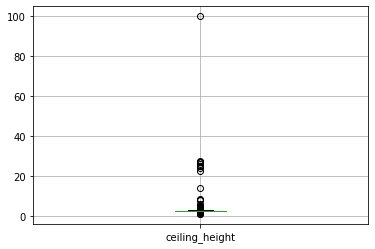

In [32]:
#График размаха для высоты потолков:
data.boxplot(column='ceiling_height')

Видно, что часть данных имеет неестественно большую величину. Узнаем, какая часть от общего количества объявлений выбивается:

In [33]:
#Какая часть от общего количества объявлений выбивается:
print(data[data['ceiling_height']>4]['last_price'].count()/data['ceiling_height'].count())

0.0026637069922308544


0,3% не так много, однако поправить их нужно. Вероятнее всего произошла ошибка при вводе числа (вместо 2,5, например, ввели 25).

In [34]:
#Характеристика изначальных данных:
print(data['ceiling_height'].mean())
print(data['ceiling_height'].median())

2.7132103218645947
2.65


In [35]:
#Обработка выбросов:
def normal_height(height):
        if height>4:
            height /= 10
        else:
            height == height
        return height

data['ceiling_height'] = data['ceiling_height'].apply(normal_height)

Мы знаем, что одно значение явно выбивается из общего массива, поэтому просто удалим его.

In [36]:
#Удалим явный выброс
data = data[data.ceiling_height < 4]

Построим график размаха ещё раз

<AxesSubplot:>

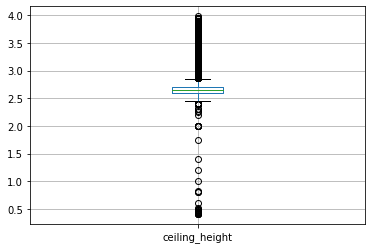

In [37]:
data.boxplot(column='ceiling_height')

Теперь мы видим, что присутствуют нереалистично маленькие значения (потолки ниже 2 метров). Узнаем их долю от общего числа:

In [38]:
print(data[data['ceiling_height']<2]['last_price'].count()/data['ceiling_height'].count())

0.0021114630216147135


Доля составляет меньше 1%, поэтому просто удаляем их:

In [39]:
#Удаляем явные аномалии:
data = data[data.ceiling_height > 2]

Сравним среднее и медиану обновлённых данных и начальных:

In [40]:
#Характеристики выборки
print(data['ceiling_height'].mean())
print(data['ceiling_height'].median())

2.686628975658664
2.65


Медиана не изменилась, среднее приблизилось к её значению. Сортировка данных по столбцу "ceiling_height" прошла успешно.

<AxesSubplot:>

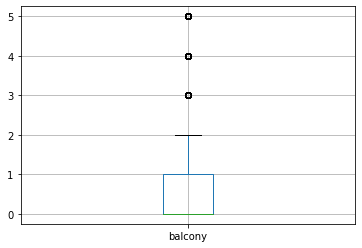

In [41]:
#Для столбца "balcony":
data.boxplot(column='balcony')

Планировки бывают разные, 5 балконов в виде исключения тоже имеет место быть. Построим столбчатую диаграмму для этого столбца

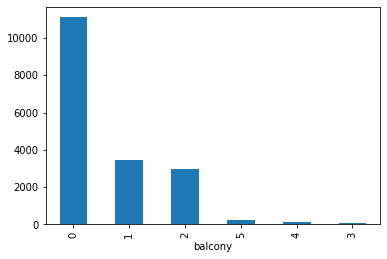

In [42]:
#Столбчатую диаграмму для этого столбца:
ax = data.value_counts('balcony').plot.bar()
plt.show()

Как видим, 5 балконов ещё и не самый редкий случай. Оставляем столбец без изменений.

<AxesSubplot:>

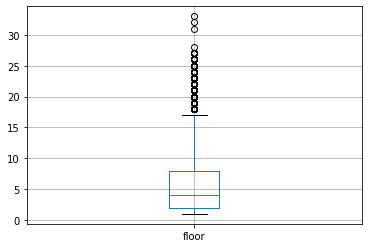

In [43]:
#Проверим столбец "floor":
data.boxplot(column='floor')

Максимальная этажность, как уже было выявлено ранее, составляет 52 этажа. Таким образом, выбросов нет.

<AxesSubplot:>

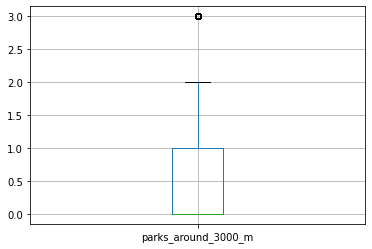

In [44]:
#Столбец "parks_around_3000_m":
data.boxplot(column='parks_around_3000_m')

Выбросов не наблюдается.

<AxesSubplot:>

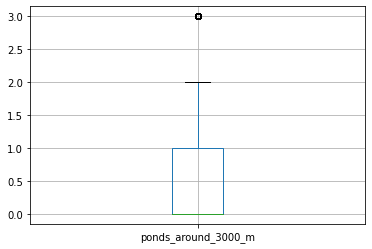

In [45]:
#Столбец "ponds_around_3000_m":
data.boxplot(column='ponds_around_3000_m')

Выбросов не наблюдается. Интересно подметить, как и в случае с парками, максимальное количество доступных "зелёных зон" 3 штуки.

<AxesSubplot:>

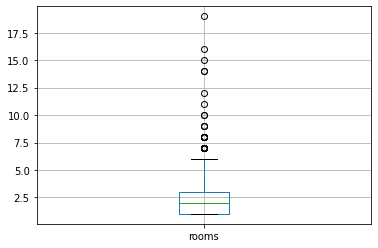

In [46]:
#Столбец "rooms". Конечно, тут дело планировки, но проверить на аномально большие значения стоит:
data.boxplot(column='rooms')

Убедимся, что рекордсмен по комнатам действительно таковым является.

In [47]:
#Выведем аномальное значение:
print(data[data['rooms']>17])

       total_images  last_price  total_area first_day_exposition  rooms  \
14498             6  32250000.0       374.6           2018-06-09     19   

       ceiling_height  floors_total  living_area  floor  is_apartment  ...  \
14498            2.65             5        264.5      2          True  ...   

       kitchen_area  balcony    locality_name  airports_nearest  \
14498          27.6        0  Санкт-Петербург           19497.0   

      city_centers_nearest  parks_around_3000_m  parks_nearest  \
14498               3574.0                  0.0          453.0   

       ponds_around_3000_m  ponds_nearest  days_exposition  
14498                  2.0          548.0              114  

[1 rows x 22 columns]


Действительно, при общей площади в 374,6 квадратных метра такое возможно. Ну и ценник у помещения соответствующий.

Убедимся, что у нас отсутствуют строки-дубликаты:

In [48]:
#Проверка на явные дубликаты:
data.duplicated().sum()

0

#### Итог предобработки данных:

1) Обработаны все пропущенные значения:\
   а) Пропуски заменены медианными значениями в столбцах "ceiling_height", "living_area", "kitchen_area", "airports_nearest", "city_centers_nearest", "parks_nearest", "ponds_nearest", "days_exposition";\
   б) Целиком удалены данные с пропусками в столбцах "floors_total", "locality_name";\
   в) Пропуски заменены 0 в столбцах "balcony", "parks_around_3000_m", "ponds_around_3000_m";\
   г) Некоторые пропуски были ликвидированы путём изменения типа данных в столбце - "is_apartment".
   
2) Изменены типы данных в столбцах "is_apartment", "balcony" и "first_day_exposition".

3) Обработаны аномалии в столбцах "rooms" и "airports_nearest".

4) Изменены названия 3 столбцов.

5) В столбце "locality_name" удалены неявные повторы.

6) Обработаны выбросы в столбцах с количественными данными.



### Посчитайте и добавьте в таблицу новые столбцы

Добавим в таблицу новые столбцы, необходимые для дальнейшего анализа.

In [49]:
#Цена одного квадратного метра (делим стоимость объекта на его общую площадь):
data['price_per_sq_m'] = data['last_price'] / data['total_area']
data['price_per_sq_m'] = data['price_per_sq_m'].round(2)
print(data['price_per_sq_m'].head())

1     82920.79
2     92785.71
4    100000.00
5     95065.79
6     99195.71
Name: price_per_sq_m, dtype: float64


In [50]:
#День публикации объявления в чсиленном виде (0 - понедельник, 1 - вторник и т.д.):
data['weekday_of_pub'] = data['first_day_exposition'].dt.weekday
print(data['weekday_of_pub'].head())

1    1
2    3
4    1
5    0
6    3
Name: weekday_of_pub, dtype: int64


In [51]:
#Месяц публикации:
data['month_of_pub'] = data['first_day_exposition'].dt.month_name()
print(data['month_of_pub'].head())

1     December
2       August
4         June
5    September
6     November
Name: month_of_pub, dtype: object


In [52]:
#Год публикации:
data['year_of_pub'] = data['first_day_exposition'].dt.year
print(data['year_of_pub'].head())

1    2018
2    2015
4    2018
5    2018
6    2017
Name: year_of_pub, dtype: int64


In [53]:
#Тип этажа квартиры:
def floor_search(row):
    floor = row['floor']
    floors_total = row['floors_total']
    if floor == 1:
        return 'первый'
    elif floor == floors_total:
        return 'последний'
    else:
        return 'другой'

data['type_of_floor'] = data.apply(floor_search, axis = 1)
print(data['type_of_floor'].head())

1    первый
2    другой
4    другой
5    другой
6    другой
Name: type_of_floor, dtype: object


In [54]:
#Проверка функции категоризации этажей:
print(data['type_of_floor'].unique())

['первый' 'другой' 'последний']


In [55]:
#Расстояние в км до центра города:
data['to_centre_km'] = data['city_centers_nearest'] / 1000
data['to_centre_km'] = data['to_centre_km'].round(0)
print(data['to_centre_km'].head())

1    19.0
2    14.0
4     8.0
5    13.0
6    19.0
Name: to_centre_km, dtype: float64


Взглянем на первые строчки дополненной таблицы и убедимся, что всё в порядке.

In [56]:
#Проверка на порядок в таблице
print(data.head())

   total_images  last_price  total_area first_day_exposition  rooms  \
1             7   3350000.0        40.4           2018-12-04      1   
2            10   5196000.0        56.0           2015-08-20      2   
4             2  10000000.0       100.0           2018-06-19      2   
5            10   2890000.0        30.4           2018-09-10      1   
6             6   3700000.0        37.3           2017-11-02      1   

   ceiling_height  floors_total  living_area  floor  is_apartment  ...  \
1            2.65            11         18.6      1          True  ...   
2            2.65             5         34.3      4          True  ...   
4            3.03            14         32.0     13          True  ...   
5            2.65            12         14.4      5          True  ...   
6            2.65            26         10.6      6          True  ...   

   parks_nearest  ponds_around_3000_m  ponds_nearest  days_exposition  \
1          453.0                  0.0          503.0   

На этом этапе стало понятно, что типы данных в некоторых столбцах можно пересмотреть:

In [57]:
#Обновление типов данных:
data['parks_around_3000_m'] = data['parks_around_3000_m'].astype('int')
data['ponds_around_3000_m'] = data['ponds_around_3000_m'].astype('int')
data['to_centre_km'] = data['to_centre_km'].astype('int')
data['last_price'] = data['last_price'].astype('int')

Посмотрим на итоговую таблицу данных.

In [58]:
#Итоговая таблица будет выглядеть следующим образом:
data.info()
print(data.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17953 entries, 1 to 23695
Data columns (total 28 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          17953 non-null  int64         
 1   last_price            17953 non-null  int64         
 2   total_area            17953 non-null  float64       
 3   first_day_exposition  17953 non-null  datetime64[ns]
 4   rooms                 17953 non-null  int64         
 5   ceiling_height        17953 non-null  float64       
 6   floors_total          17953 non-null  int64         
 7   living_area           17953 non-null  float64       
 8   floor                 17953 non-null  int64         
 9   is_apartment          17953 non-null  bool          
 10  studio                17953 non-null  bool          
 11  open_plan             17953 non-null  bool          
 12  kitchen_area          17953 non-null  float64       
 13  balcony         

#### Вывод: 
В таблицу были успешно внесены 6 новых столбцов, которые помогут в дальнейшем анализе данных. Также произведена доработка типов данных в некоторых столбцах. Теперь таблица полностью готова к анализу данных.

### Проведите исследовательский анализ данных

#### Проверим некоторые столбцы на явные выбросы. 
Часть этой работы уже была проведена в предобработке данных, сейчас разберёмся со следующими столбцами: общая площадь,  жилая площадь, площадь кухни, цена объекта, общее количество этажей в доме,  расстояние до центра города в метрах, расстояние до ближайшего аэропорта, расстояние до ближайшего парка.

##### Общая площадь

count    17953.000000
mean        58.879429
std         32.515455
min         14.000000
25%         40.000000
50%         51.000000
75%         68.000000
max        900.000000
Name: total_area, dtype: float64

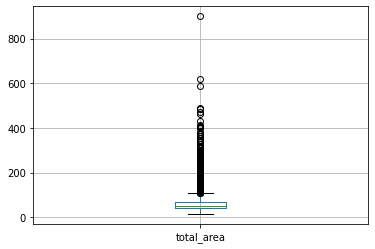

In [59]:
#График размаха для общей площади и его описание:
data.boxplot('total_area')
data['total_area'].describe()

Видим несколько значений больше 600 метров квадратных. Посмотрим, что это за объекты:

In [60]:
#Выводим аномалии:
print(data[data['total_area']>550])

       total_images  last_price  total_area first_day_exposition  rooms  \
5358             20    65000000       590.0           2019-02-14     15   
15651            20   300000000       618.0           2017-12-18      7   
19540             8   420000000       900.0           2017-12-06     12   

       ceiling_height  floors_total  living_area  floor  is_apartment  ...  \
5358              3.5             6        409.0      3          True  ...   
15651             3.4             7        258.0      5          True  ...   
19540             2.8            25        409.7     25          True  ...   

       parks_nearest  ponds_around_3000_m  ponds_nearest  days_exposition  \
5358           767.0                    0          503.0               14   
15651          453.0                    2          198.0              111   
19540          453.0                    2          318.0              106   

      price_per_sq_m  weekday_of_pub  month_of_pub  year_of_pub  \
5358      

Судя по невероятным ценникам, такие варианты имеют место быть. Таких предложений не так много, поэтому они неособо влияют на общие показатели; данные оставляем.

##### Жилая площадь

count    17953.000000
mean        33.541756
std         20.609474
min          2.000000
25%         18.500000
50%         30.000000
75%         41.800000
max        409.700000
Name: living_area, dtype: float64

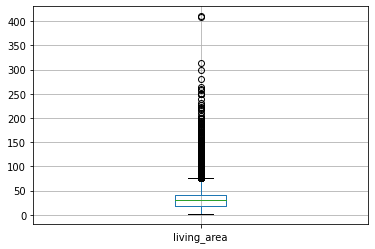

In [61]:
#Жилая площадь:
data.boxplot('living_area')
data['living_area'].describe()

Ничего необычного, согласуется с общей площадью.

##### Площадь кухни

count    17953.000000
mean        10.354447
std          5.567552
min          2.000000
25%          7.000000
50%          9.000000
75%         11.800000
max        112.000000
Name: kitchen_area, dtype: float64

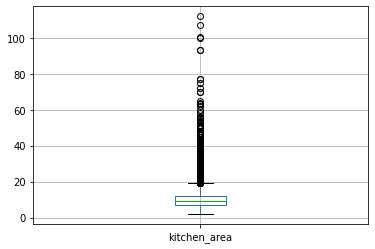

In [62]:
#Площадь кухни:
data.boxplot('kitchen_area')
data['kitchen_area'].describe()

Жилая площадь и площадь кухни соответствуют общей площади некоторых объектов. Такие данные имеют место быть.

##### Цена объекта

count    1.795300e+04
mean     6.176003e+06
std      9.184499e+06
min      1.219000e+04
25%      3.460000e+06
50%      4.550000e+06
75%      6.500000e+06
max      4.200000e+08
Name: last_price, dtype: float64

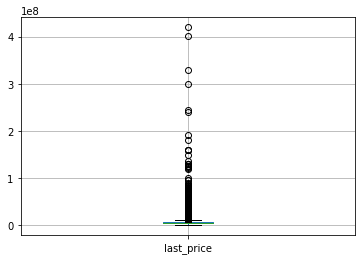

In [63]:
#Цена объекта:
data.boxplot('last_price')
data['last_price'].describe()

Посмотрим на аномальные значения.

In [64]:
#Вывод аномальных данных:
print(data[data['last_price']>400000000])

       total_images  last_price  total_area first_day_exposition  rooms  \
14706            15   401300000       401.0           2016-02-20      5   
19540             8   420000000       900.0           2017-12-06     12   

       ceiling_height  floors_total  living_area  floor  is_apartment  ...  \
14706            2.65             9        204.0      9         False  ...   
19540            2.80            25        409.7     25          True  ...   

       parks_nearest  ponds_around_3000_m  ponds_nearest  days_exposition  \
14706          545.0                    1          478.0              393   
19540          453.0                    2          318.0              106   

      price_per_sq_m  weekday_of_pub  month_of_pub  year_of_pub  \
14706     1000748.13               5      February         2016   
19540      466666.67               2      December         2017   

       type_of_floor  to_centre_km  
14706      последний             2  
19540      последний           

Апартаменты бывают разные. Ничего криминального не обнаружено, оставляем.

##### Количество этажей в доме

count    17953.000000
mean        10.756141
std          6.564784
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64

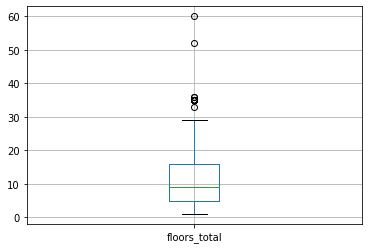

In [65]:
#Количество этажей в доме:
data.boxplot('floors_total')
data['floors_total'].describe()

Посмотрим на аномальные данные.

In [66]:
#Аномальные данные:
print(data[data['floors_total']>50])

       total_images  last_price  total_area first_day_exposition  rooms  \
2253             12     3800000        45.5           2018-06-28      2   
16731             9     3978000        40.0           2018-09-24      1   

       ceiling_height  floors_total  living_area  floor  is_apartment  ...  \
2253             2.88            60         27.4      4          True  ...   
16731            2.65            52         10.5     18          True  ...   

       parks_nearest  ponds_around_3000_m  ponds_nearest  days_exposition  \
2253           342.0                    3          614.0              166   
16731          793.0                    0          503.0               45   

      price_per_sq_m  weekday_of_pub  month_of_pub  year_of_pub  \
2253        83516.48               3          June         2018   
16731       99450.00               0     September         2018   

       type_of_floor  to_centre_km  
2253          другой            49  
16731         другой           

Прибегаем к помощи поисковых систем и понимаем, что это явно ошибочные значения. Как и в предыдущих случаях, учитывая их малое количество, сохраним эти данные.

##### Расстояние до центра города

count    17953.000000
mean        14.075475
std          7.654982
min          0.000000
25%         11.000000
50%         13.000000
75%         15.000000
max         66.000000
Name: to_centre_km, dtype: float64

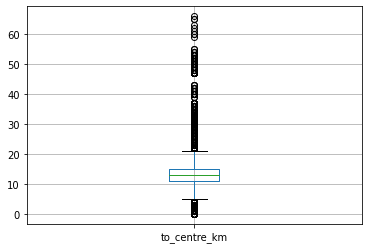

In [67]:
#Расстояние до центра города:
data.boxplot('to_centre_km')
data['to_centre_km'].describe()

Учитывая границы Ленинградской области, никаких аномалий не обнаружено.

##### Расстояние до аэропорта

count    17953.000000
mean     28388.743107
std      11314.537981
min          0.000000
25%      20643.000000
50%      26729.000000
75%      34966.000000
max      84869.000000
Name: airports_nearest, dtype: float64

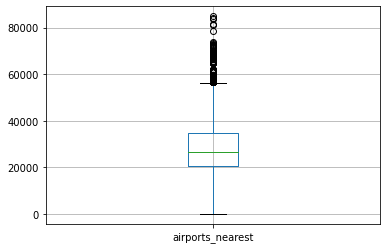

In [68]:
#Расстояние до аэропорта
data.boxplot('airports_nearest')
data['airports_nearest'].describe()

Напомним, что это расстояние в метрах. 90 км вполне реалистичная цифра.

##### Расстояние до ближайшего парка

count    17953.000000
mean       465.329694
std        200.529889
min          1.000000
25%        453.000000
50%        453.000000
75%        453.000000
max       3190.000000
Name: parks_nearest, dtype: float64

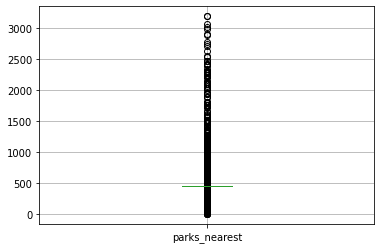

In [69]:
#Расстояние до ближайшего парка:
data.boxplot('parks_nearest')
data['parks_nearest'].describe()

Значения по большей части выглядят реалистично.

##### Построение гистограмм

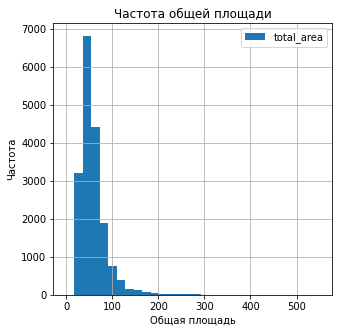

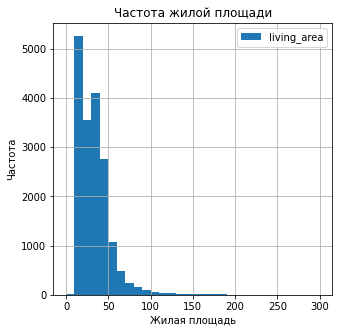

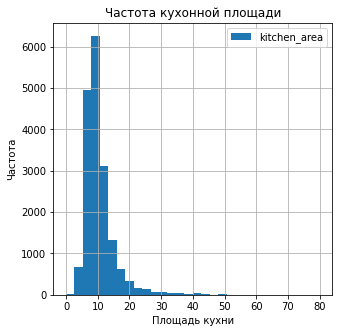

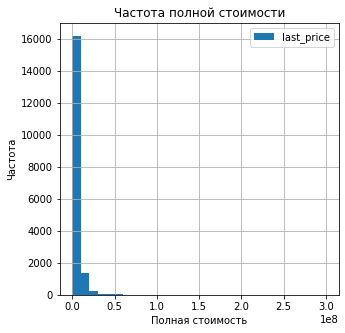

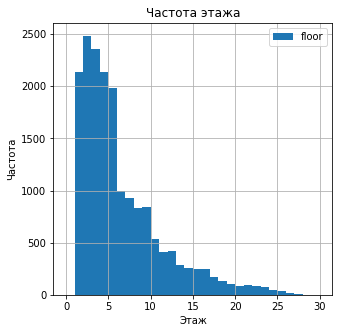

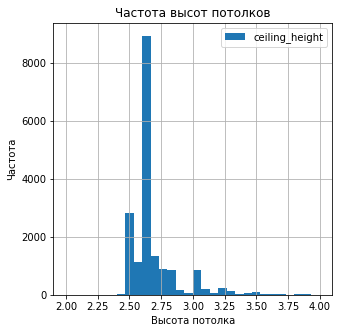

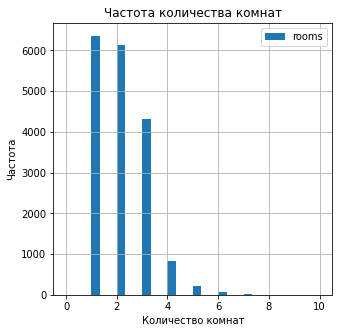

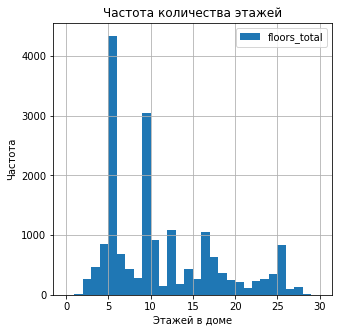

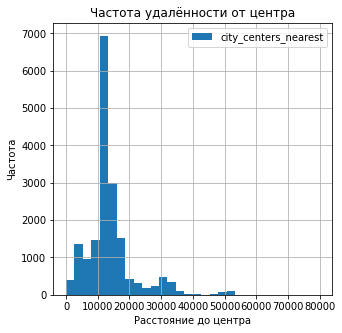

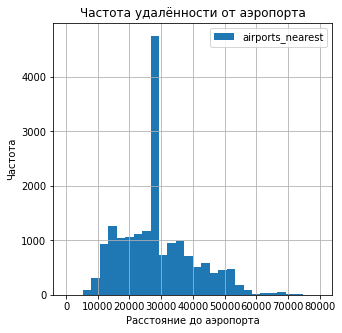

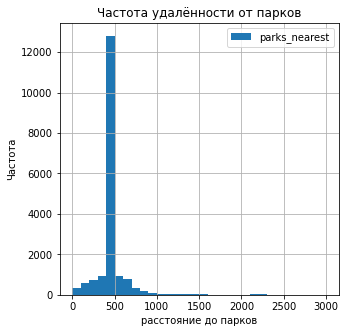

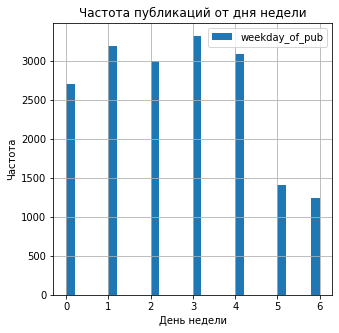

In [70]:
#Построим гистограммы для всех перечисленных параметров:
data.plot(y = 'total_area', kind = 'hist', bins = 30, range = (0,550), grid=True, figsize = (5,5))
plt.title('Частота общей площади')
plt.ylabel('Частота')
plt.xlabel('Общая площадь')
plt.show()

data.plot(y = 'living_area', kind = 'hist', bins = 30, range = (0,300), grid=True, figsize = (5,5))
plt.title('Частота жилой площади')
plt.ylabel('Частота')
plt.xlabel('Жилая площадь')
plt.show()

data.plot(y = 'kitchen_area', kind = 'hist', bins = 30, range = (0,80), grid=True, figsize = (5,5))
plt.title('Частота кухонной площади')
plt.ylabel('Частота')
plt.xlabel('Площадь кухни')
plt.show()

data.plot(y = 'last_price', kind = 'hist', bins = 30, range = (0,300000000), grid=True, figsize = (5,5))
plt.title('Частота полной стоимости')
plt.ylabel('Частота')
plt.xlabel('Полная стоимость')
plt.show()

data.plot(y = 'floor', kind = 'hist', bins = 30, range = (0,30), grid=True, figsize = (5,5))
plt.title('Частота этажа')
plt.ylabel('Частота')
plt.xlabel('Этаж')
plt.show()

data.plot(y = 'ceiling_height', kind = 'hist', bins = 30, range = (2,4), grid=True, figsize = (5,5))
plt.title('Частота высот потолков')
plt.ylabel('Частота')
plt.xlabel('Высота потолка')
plt.show()

data.plot(y = 'rooms', kind = 'hist', bins = 30, range = (0,10), grid=True, figsize = (5,5))
plt.title('Частота количества комнат')
plt.ylabel('Частота')
plt.xlabel('Количество комнат')
plt.show()

data.plot(y = 'floors_total', kind = 'hist', bins = 30, range = (0,30), grid=True, figsize = (5,5))
plt.title('Частота количества этажей')
plt.ylabel('Частота')
plt.xlabel('Этажей в доме')
plt.show()

data.plot(y = 'city_centers_nearest', kind = 'hist', bins = 30, range = (0,80000), grid=True, figsize = (5,5))
plt.title('Частота удалённости от центра')
plt.ylabel('Частота')
plt.xlabel('Расстояние до центра')
plt.show()

data.plot(y = 'airports_nearest', kind = 'hist', bins = 30, range = (0,80000), grid=True, figsize = (5,5))
plt.title('Частота удалённости от аэропорта')
plt.ylabel('Частота')
plt.xlabel('Расстояние до аэропорта')
plt.show()

data.plot(y = 'parks_nearest', kind = 'hist', bins = 30, range = (0,3000), grid=True, figsize = (5,5))
plt.title('Частота удалённости от парков')
plt.ylabel('Частота')
plt.xlabel('расстояние до парков')
plt.show()

data.plot(y = 'weekday_of_pub', kind = 'hist', bins = 30, range = (0,6), grid=True, figsize = (5,5))
plt.title('Частота публикаций от дня недели')
plt.ylabel('Частота')
plt.xlabel('День недели')
plt.show()

Для построения гистограммы по месяцам добавим столбец с номерами месяцов, по ним же и будем производить построения:

In [71]:
#Номера месяцев:
data['month'] = data['first_day_exposition'].dt.month

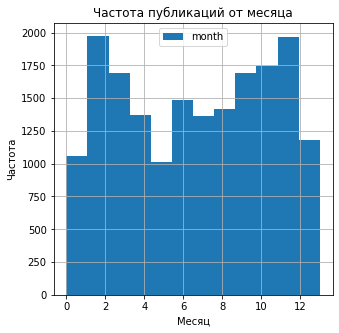

In [72]:
#Гистограмма по месяцам:
data.plot(y = 'month', kind = 'hist', bins = 12, range = (0,13), grid=True, figsize = (5,5))
plt.title('Частота публикаций от месяца')
plt.ylabel('Частота')
plt.xlabel('Месяц')
plt.show()

Для построения гистограмм нужны численные данные, поэтому закодируем типы этажей, добавим новый столбец с ними.

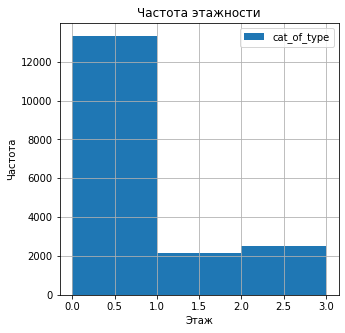

In [73]:
#Категоризация:
def categorize_type(type):
    try:
        if type == 'первый':
            return 1
        elif type == 'последний':
            return 2
        elif type == 'другой':
            return 0
    except:
        pass
    
data['cat_of_type'] = data['type_of_floor'].apply(categorize_type)
data.plot(y = 'cat_of_type', kind = 'hist', bins = 3, range = (0,3), grid=True, figsize = (5,5))
plt.title('Частота этажности')
plt.ylabel('Частота')
plt.xlabel('Этаж')
plt.show()

##### Промежуточный вывод: 
Проанализировав все столбцы с количественными переменными можно сказать о том, что конкретные ошибки были допущены в столбце с высотой потолков (были аномально большие и аномально низкие значения, часть из них удалили), а также в столбце с общим количеством этажей (конкретно дом 60 этажей в Кронштадте и 52 в Санкт-Петербурге, не удаляли, так как особой роли не играют); остальные выбросы не являлись критическими, объяснялись уникальностью продаваемых объектов.\
По гистограммам: у подавляющего большинства вариантов общая площадь варьируется от 20 до 60 квадратных метров; около 85% вариантов были выставлены по цене не превышающей 20 млн рублей; предложений в малоэтажных домах в несколько раз больше; в основном помещения имеют высоту потолков от 2,5 до 2,7 метров; преобладают классические квартиры с 1, 2 или 3 комнатами; объявления о продаже публикуются заметно чаще в будние дни; по общему количесту предложений наблюдался спад в мае; предложения по квартирам на первых и последних этажах в доме составляют примерно одинаковую долю по рынку.

#### Разберёмся, как быстро продавались квартиры
Для этого необходимо проанализировать столбец "days_exposition". Построим гистограмму, посчитаем среднее и медиану.

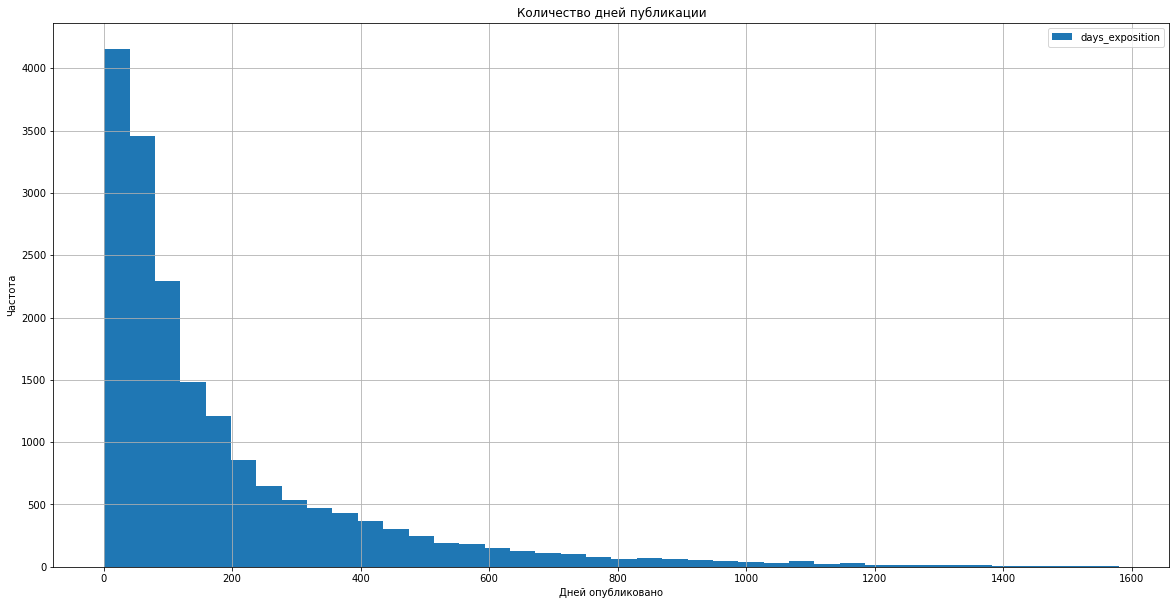

count    17953.000000
mean       185.117975
std        221.695771
min          1.000000
25%         45.000000
50%        102.000000
75%        238.000000
max       1580.000000
Name: days_exposition, dtype: float64

In [74]:
#Построим гистограмму по целому столбцу, выведем среднее и медиану.
data.plot(y = 'days_exposition', kind = 'hist', bins=40, grid=True, figsize=(20, 10))
plt.title('Количество дней публикации')
plt.ylabel('Частота')
plt.xlabel('Дней опубликовано')
plt.show()

data['days_exposition'].describe()

Видим, что около половины объявлений "провисели" не более 200 дней. Рассмотрим этот промежуток внимательнее.

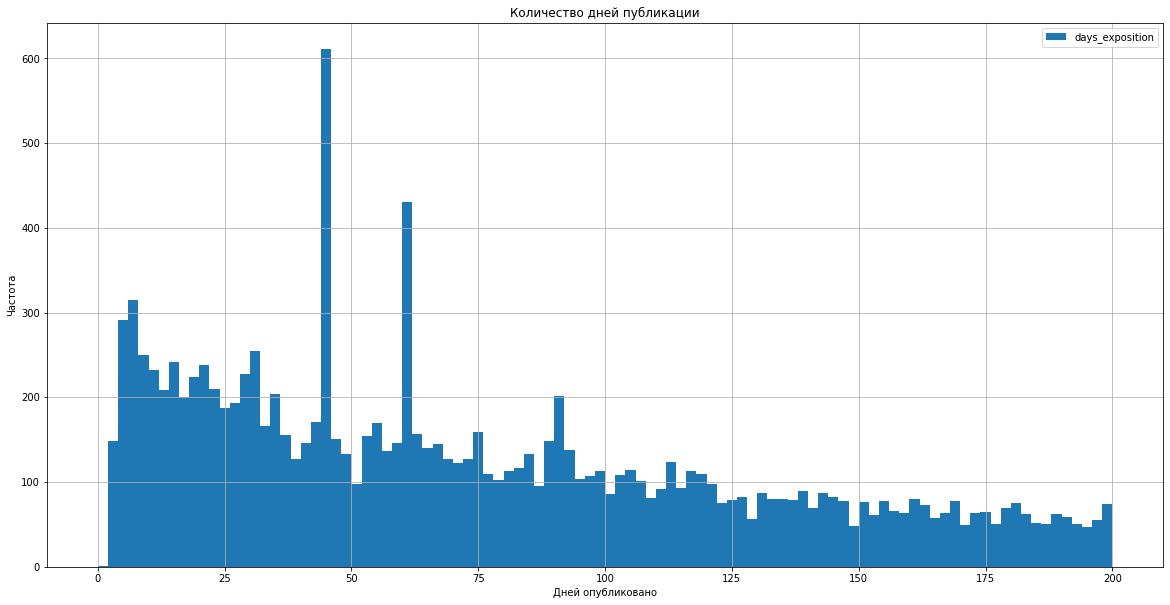

In [75]:
#Исследуем конкретную область:
data.plot(y = 'days_exposition', kind = 'hist', bins=100, grid=True, figsize=(20, 10), range=(0, 200))
plt.title('Количество дней публикации')
plt.ylabel('Частота')
plt.xlabel('Дней опубликовано')
plt.show()

Наблюдаем 3 аномально больших выброса: 45, 60 и 90 дней. Значения явно что-то значат, имеет смысл предположить, что часть объявлений удаляется автоматически, спустя определённый промежуток времени. Посмотрим, сколько это в цифрах.

In [76]:
#Исследуем выбросы:
print(data[data['days_exposition']==45]['days_exposition'].count())
print(data[data['days_exposition']==60]['days_exposition'].count())
print(data[data['days_exposition']==90]['days_exposition'].count())

517
339
136


Так как уточнить данные не представляется возможным, продолжим анализ, удалив найденные выбросы:

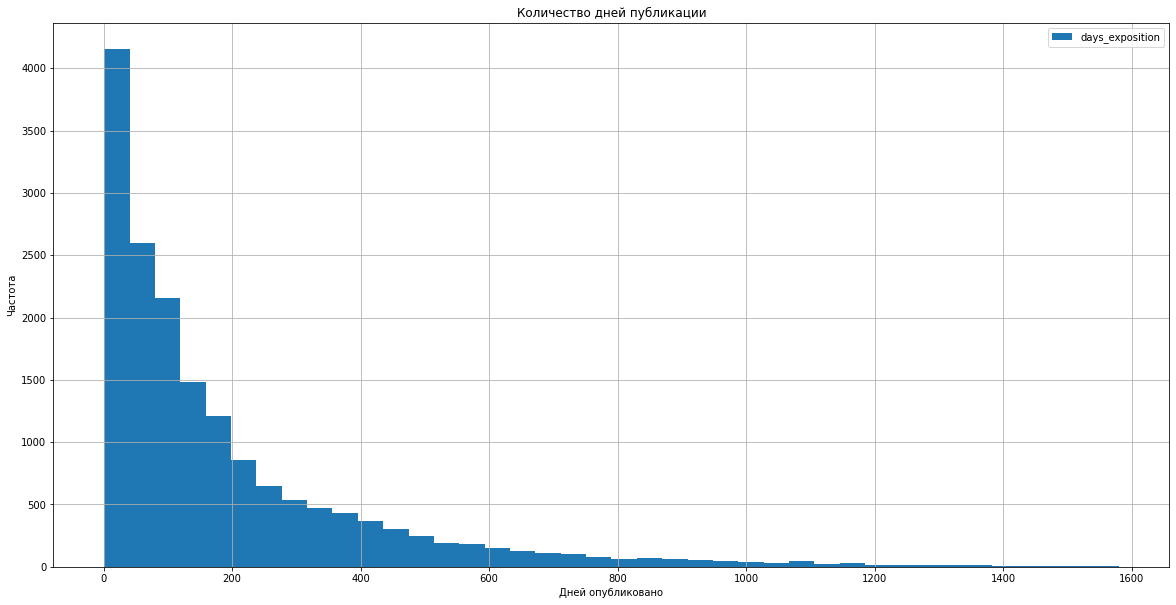

count    16961.000000
mean       192.652438
std        225.794281
min          1.000000
25%         42.000000
50%        112.000000
75%        253.000000
max       1580.000000
Name: days_exposition, dtype: float64

In [77]:
#Удаляем выбросы:
good_days = data.query('days_exposition != 45 and days_exposition != 60 and days_exposition != 90')

#Теперь построим гистограмму по "очищенным" данным, выведем среднее и медиану:
good_days.plot(y = 'days_exposition', kind = 'hist', bins=40, grid=True, figsize=(20, 10))
plt.title('Количество дней публикации')
plt.ylabel('Частота')
plt.xlabel('Дней опубликовано')
plt.show()

good_days['days_exposition'].describe()

Для наглядного представления аномальных значений построим диаграмму размаха:

<AxesSubplot:>

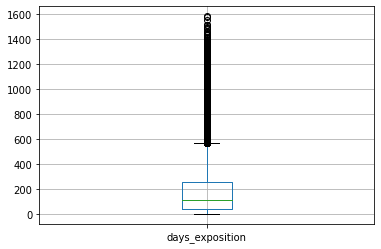

In [78]:
#Диаграмма размаха:
good_days.boxplot(column='days_exposition')

##### Промежуточный вывод:
В ходе анализа дней размещения объявлений были обнаружены 3 критических аномалии (45, 60 и 90 дней). Предполагаем, что это срок автоматического удаления объявления с площадки по какой-то причине. Чтобы подтвердить данную гипотезу, необходимо обратиться в тех. поддержку сервиса.\
После удаления выбросов получили следующую информацию: около половины объявлений было снято спустя 200 дней после размещения; среднее время размещения составляет 192 дня, медианное значение - 112; аномально долгим размещением можем считать 570+ дней (Q3 + 1,5IQR), аномально короткое - 1 день.

#### Факторы, влияющие на полную стоимость объекта
Построим графики зависимости стоимости помещения от значений следующих столбцов:  
  - общей площади;
  - жилой площади;
  - площади кухни;
  - количество комнат;
  - типа этажа, на котором расположена квартира (первый, последний, другой);
  - даты размещения (день недели, месяц, год)

##### Общая площадь

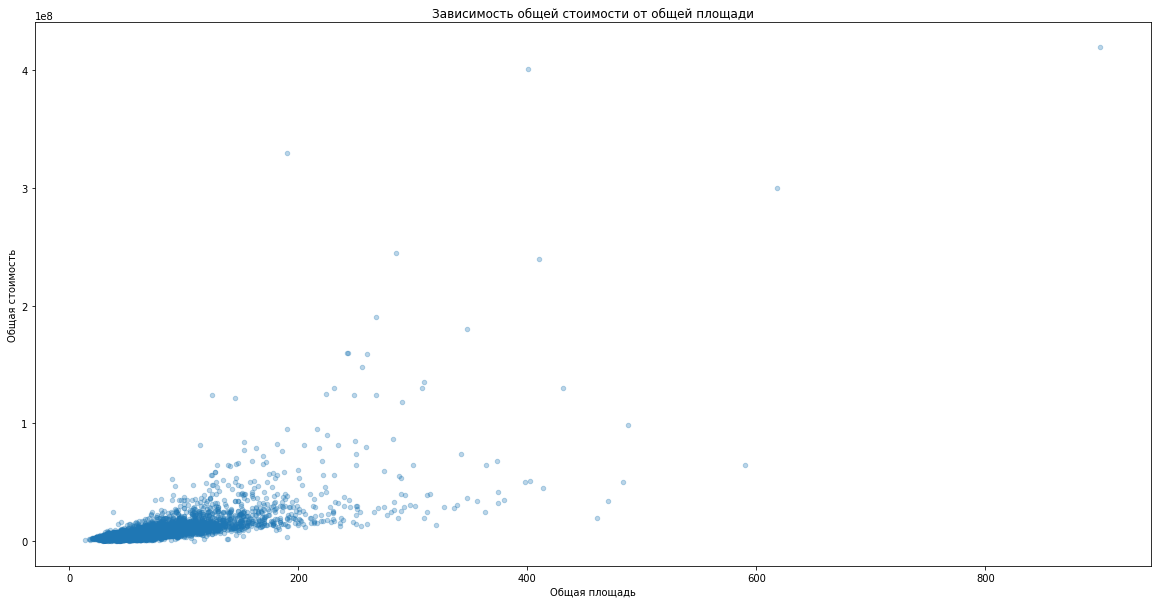

In [79]:
#Зависимость от общей площади:
data.plot(x = 'total_area', y = 'last_price', kind = 'scatter', figsize = (20,10), alpha = 0.3)
plt.title('Зависимость общей стоимости от общей площади')
plt.ylabel('Общая стоимость')
plt.xlabel('Общая площадь')
plt.show()

На первый взгляд зависимость есть. Посчитаем коэффицинт корреляции Пирсона:

In [80]:
data['last_price'].corr(data['total_area'])

0.6797083504350426

Связь характеризуется как средняя возрастающая, т.е. с увеличением площади помещения ценник повышается.

##### Жилая площадь

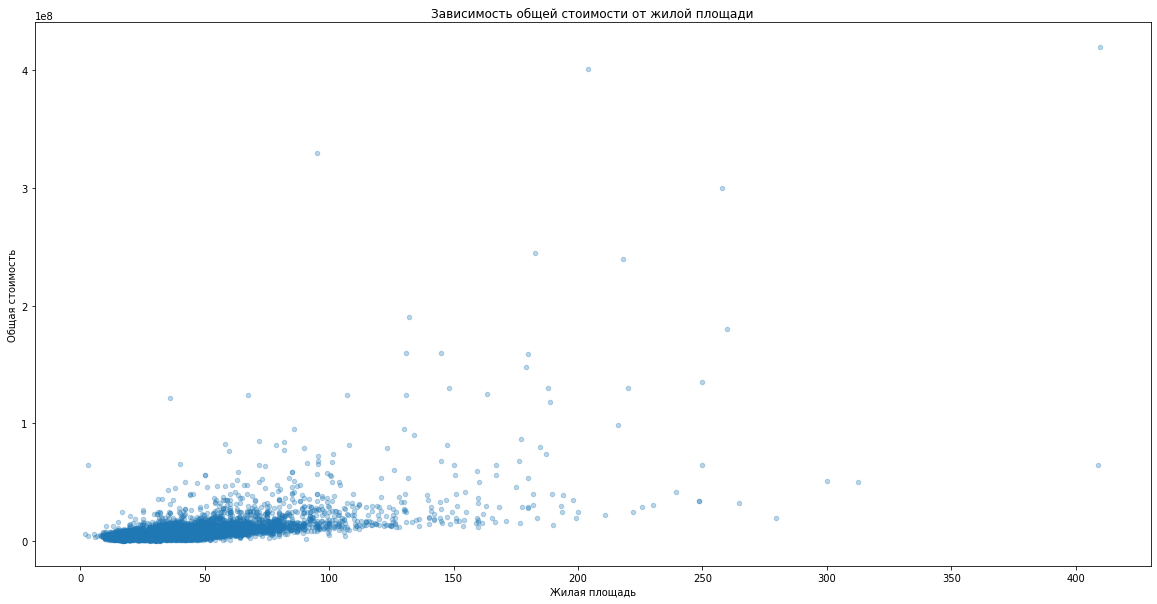

In [81]:
#Зависимость от жилой площади:
data.plot(x = 'living_area', y = 'last_price', kind = 'scatter', figsize = (20,10), alpha = 0.3)
plt.title('Зависимость общей стоимости от жилой площади')
plt.ylabel('Общая стоимость')
plt.xlabel('Жилая площадь')
plt.show()

Посчитаем коэффицинт корреляции Пирсона:

In [82]:
data['last_price'].corr(data['living_area'])

0.5851123207163498

Как и в случае с общей площадью зависимость действительно есть: средняя возрастающая.

##### Площадь кухни

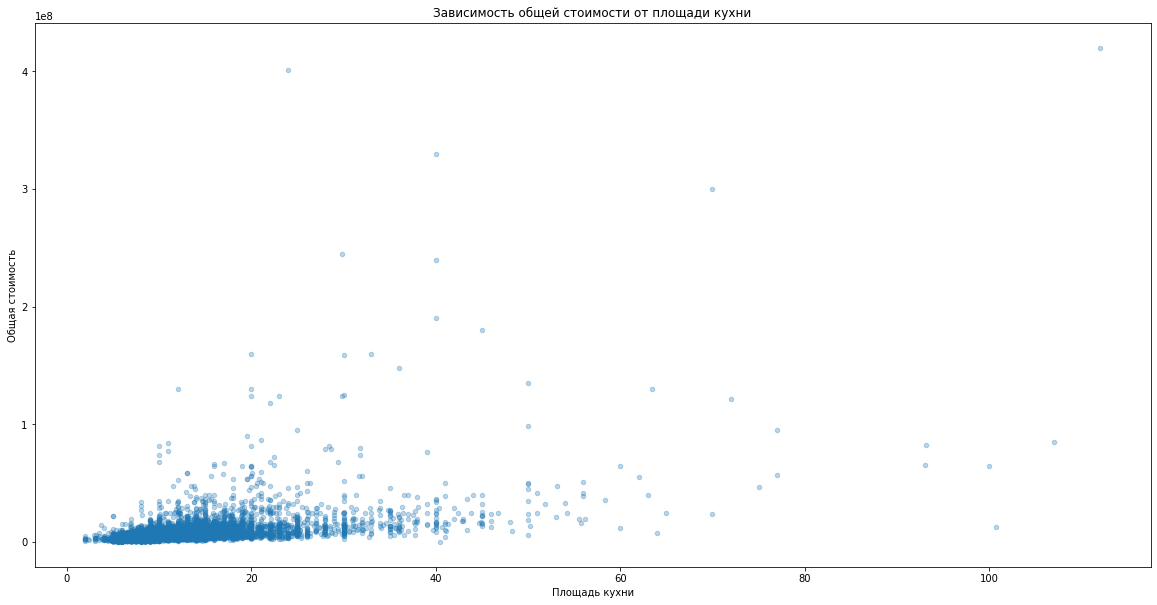

In [83]:
#Зависимость от площади кухни:
data.plot(x = 'kitchen_area', y = 'last_price', kind = 'scatter', figsize = (20,10), alpha = 0.3)
plt.title('Зависимость общей стоимости от площади кухни')
plt.ylabel('Общая стоимость')
plt.xlabel('Площадь кухни')
plt.show()

Коэффициент корреляции Пирсона:

In [84]:
data['last_price'].corr(data['kitchen_area'])

0.5041658416905151

Самая маленькая связь среди площадей, тем не менее так же средняя возрастающая.

##### Количество комнат

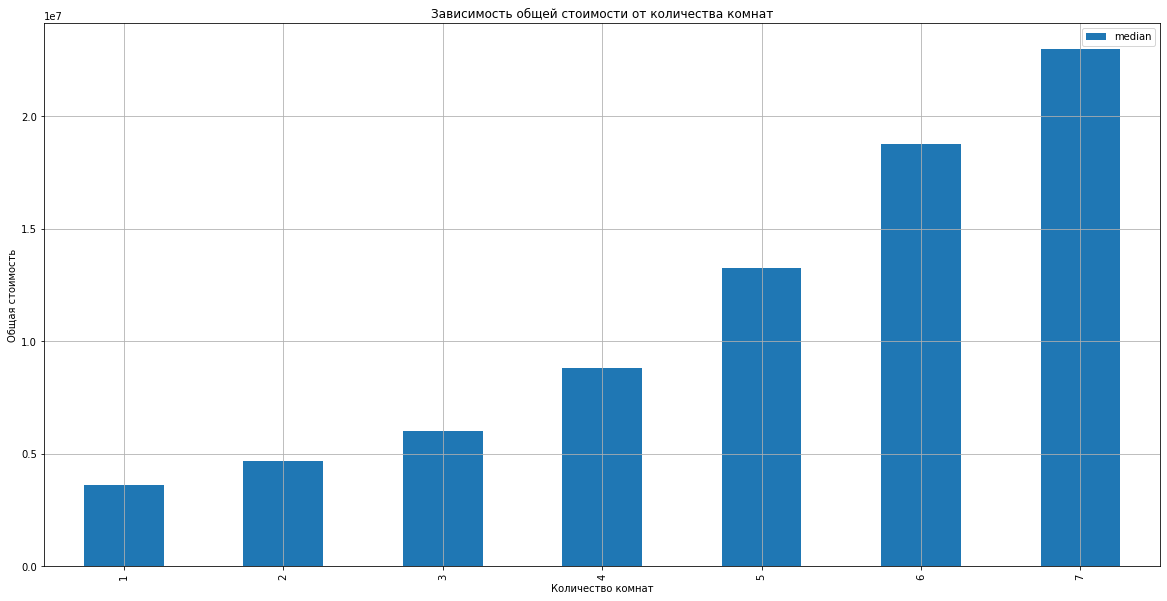

In [85]:
#Зависимость от количества комнат: 
pivot_table_rooms = data.pivot_table(index = 'rooms', values = 'last_price', aggfunc = ['mean', 'median', 'count'])
pivot_table_rooms.columns = ['mean', 'median', 'count']

#График будем строить с ограничениями по количеству предложений, так как без них информативность сильно снижается:
pivot_table_rooms.query('count > 30').plot(y = 'median', kind='bar', grid=True, figsize=(20, 10))
plt.title('Зависимость общей стоимости от количества комнат')
plt.ylabel('Общая стоимость')
plt.xlabel('Количество комнат')
plt.show()

Видим обыкновенную линейную зависимость: чем больше комнат, тем больше ценник. Как и в случае с площадью, не какой-то закон, но очевидная корреляция есть.

##### Тип этажа

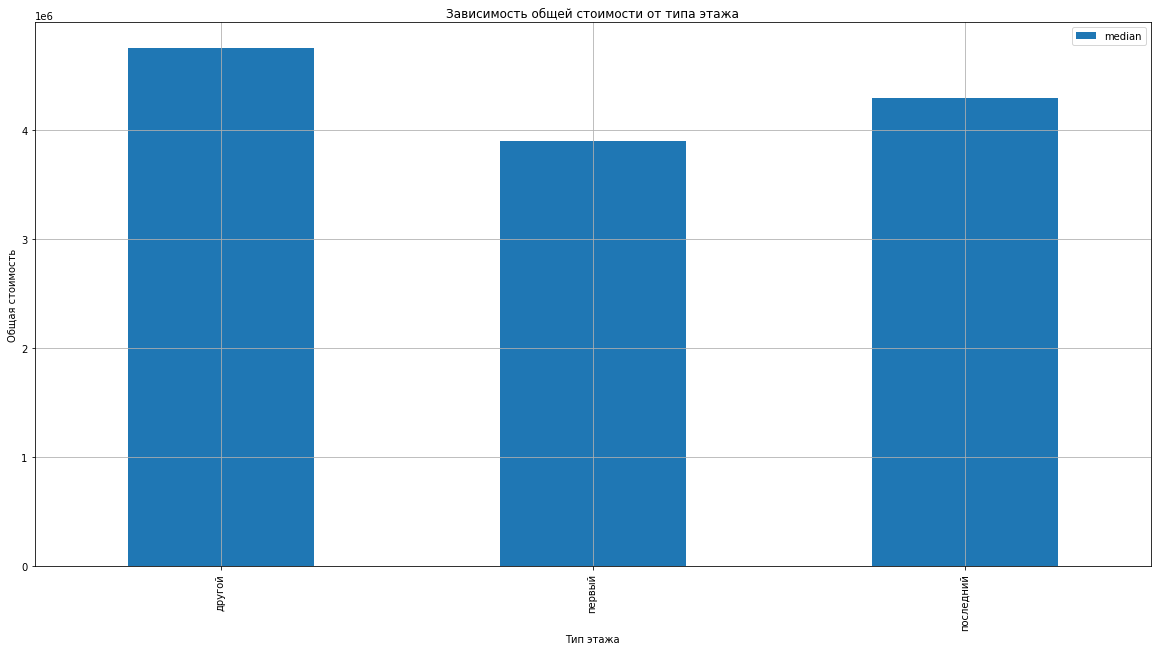

In [86]:
#Зависимость от типа этажа: 
pivot_table_rooms = data.pivot_table(index = 'type_of_floor', values = 'last_price', aggfunc = ['mean', 'median', 'count'])
pivot_table_rooms.columns = ['mean', 'median', 'count']

pivot_table_rooms.plot(y = 'median', kind='bar', grid=True, figsize=(20, 10))
plt.title('Зависимость общей стоимости от типа этажа')
plt.ylabel('Общая стоимость')
plt.xlabel('Тип этажа')
plt.show()

Очевидно, что наибольший ценник у предложений категории "другие", их в выборке представлено куда больше. Люди предпочитают квартиры не на первых этажах. Видимо, боятся излишнего шума, автомобильных выхлопов и т.д.

##### День недели

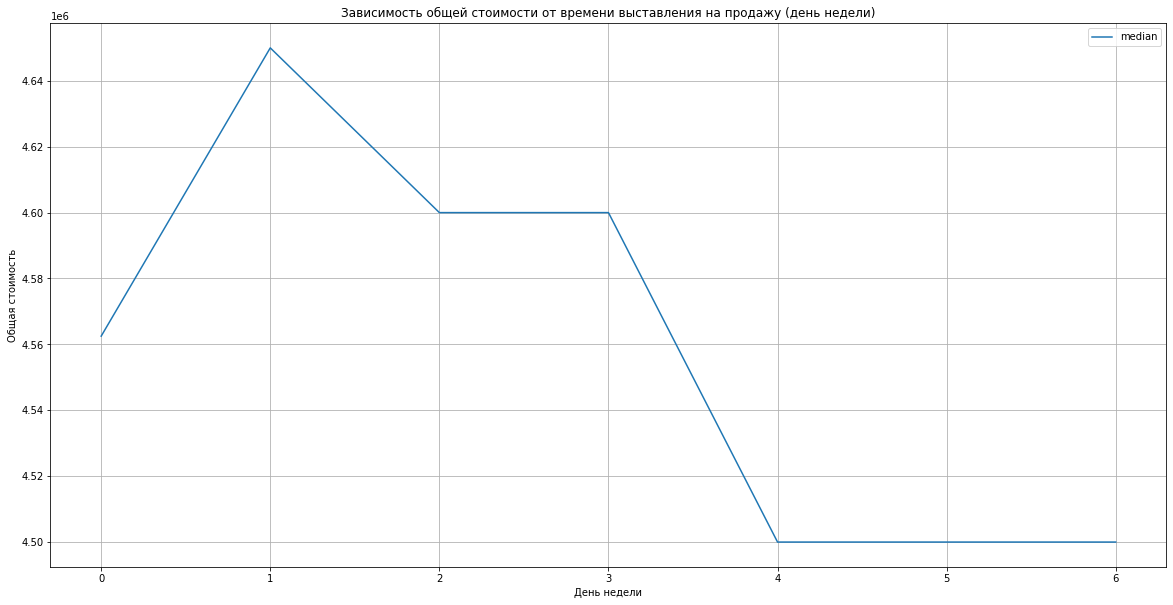

In [87]:
#Зависимость от дня недели: 
pivot_table_rooms = data.pivot_table(index = 'weekday_of_pub', values = 'last_price', aggfunc = ['mean', 'median', 'count'])
pivot_table_rooms.columns = ['mean', 'median', 'count']

pivot_table_rooms.plot(y = 'median', grid=True, figsize=(20, 10))
plt.title('Зависимость общей стоимости от времени выставления на продажу (день недели)')
plt.ylabel('Общая стоимость')
plt.xlabel('День недели')
plt.show()

Наибольшие ценники выставляются у предложений, опубликованных во вторник, явная просадка видна в пятницу, субботу и воскресенье. Это может быть связано с тем, что многие люди пользуются услугами риелторских агенств: в будние дни они выбрасывают на рынок большое количество предложений, за счёт чего поднимается общий ценник. В выходные дни активность, понятное дело, ниже.

##### Месяц года

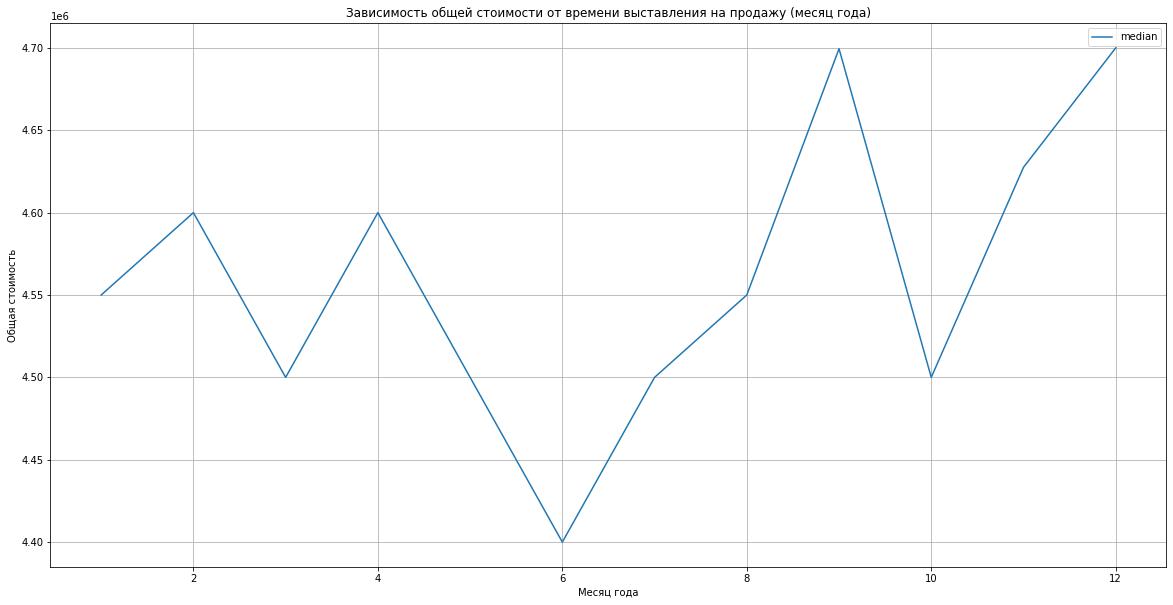

In [88]:
#Зависимость от месяца года: 
pivot_table_rooms = data.pivot_table(index = 'month', values = 'last_price', aggfunc = ['mean', 'median', 'count'])
pivot_table_rooms.columns = ['mean', 'median', 'count']

pivot_table_rooms.plot(y = 'median', grid=True, figsize=(20, 10))
plt.title('Зависимость общей стоимости от времени выставления на продажу (месяц года)')
plt.ylabel('Общая стоимость')
plt.xlabel('Месяц года')
plt.show()

В целом видна просадка в июне; видимо, "зима" на рынке недвижимости наступает в начале лета, когда людям меньше всего хочется работать. Пики в сентябре и декабре: в сентябре есть возможность взять отпуск и переехать/сделать ремонт по ещё нормальной погоде, в декабре расчёт может идти на праздничное настроение людей. Просадки в марте и октябре можно объяснить как передышку рынка между 2 пиками.

##### Год

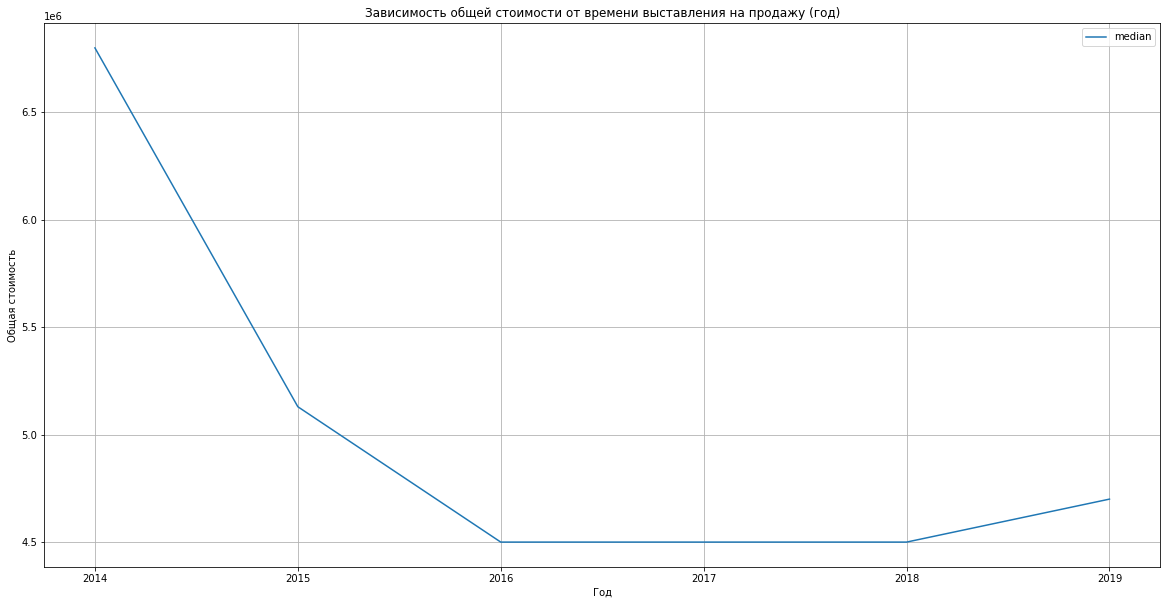

In [89]:
#Зависимость от дня недели: 
pivot_table_rooms = data.pivot_table(index = 'year_of_pub', values = 'last_price', aggfunc = ['mean', 'median', 'count'])
pivot_table_rooms.columns = ['mean', 'median', 'count']

pivot_table_rooms.plot(y = 'median', grid=True, figsize=(20, 10))
plt.title('Зависимость общей стоимости от времени выставления на продажу (год)')
plt.ylabel('Общая стоимость')
plt.xlabel('Год')
plt.show()

После событий 14 года очевидна крупная просадка, рынок находился в упадке несколько лет и к 2019 году только начал восстанавливаться.

##### Промежуточный вывод:
Проанализировани некоторые факторы, которые в теории могли бы влиять на стоимость квадратного метра помещения, пришли к следующим выводам:
1) Общая площадь является вполне определяет стоимость помещения. С её ростом наблюдается повышение цены, коэффициент корреляции около 0,68;\
2) Жилая площадь реальный фактор, коэффициент корреляции составляет 0,59;\
3) Площадь кухни слабее связана с общей стоимостью, но связь так же является средней возрастающей, коэффициент корреляции 0,5;\
4) Количество комнат влияет на стоимость объекта: чем больше комнат, тем больше цена; зависимость практически линейная;\
5) Тип этажа также достаточно показательный фактор: ценник на квартиры на первых этажах заметно ниже. Людям может не нравится излишняя близость улицы (шум, автомобильные выхлопы и т.д.); \
6) Дата размещения влияет на цену квадратного метра: 
 - по дням недели - наиболее крупные предложения выбрасываются на рынок во вторник, в пятницу и выходные наблюдается спад (это может быть связано с деятельностью риелторских компаний);
 - по месяцам - явный пик приходится на сентябрь и декабрь (предполагаем, что связано с наступление времени, когда можно с комфортом переезжать и делать ремонт), спад наблюдается в июне (все крупные предложения уже были выставлены, присутствует общее желание людей отдыхать, а не заниматься чем-то), в остальное время рынок достаточно стабилен;
 - по годам - крупный спад после событий 14 года, рынок начал снова расти только к 2019 году.

#### Средняя цена одного квадратного метра в топ-10 нас. пунктах по количеству объявлений
Необходимо выделить населённые пункты с самой высокой и низкой стоимостью квадратного метра.

                   count      median
locality_name                       
Санкт-Петербург    12102  102564.100
Мурино               425   85322.580
поселок Шушары       366   76573.505
Кудрово              346   94475.985
Всеволожск           300   65789.470
Колпино              292   73820.925
Пушкин               276   97781.735
поселок Парголово    264   92097.070
Гатчина              251   67173.910
Петергоф             168   81042.230


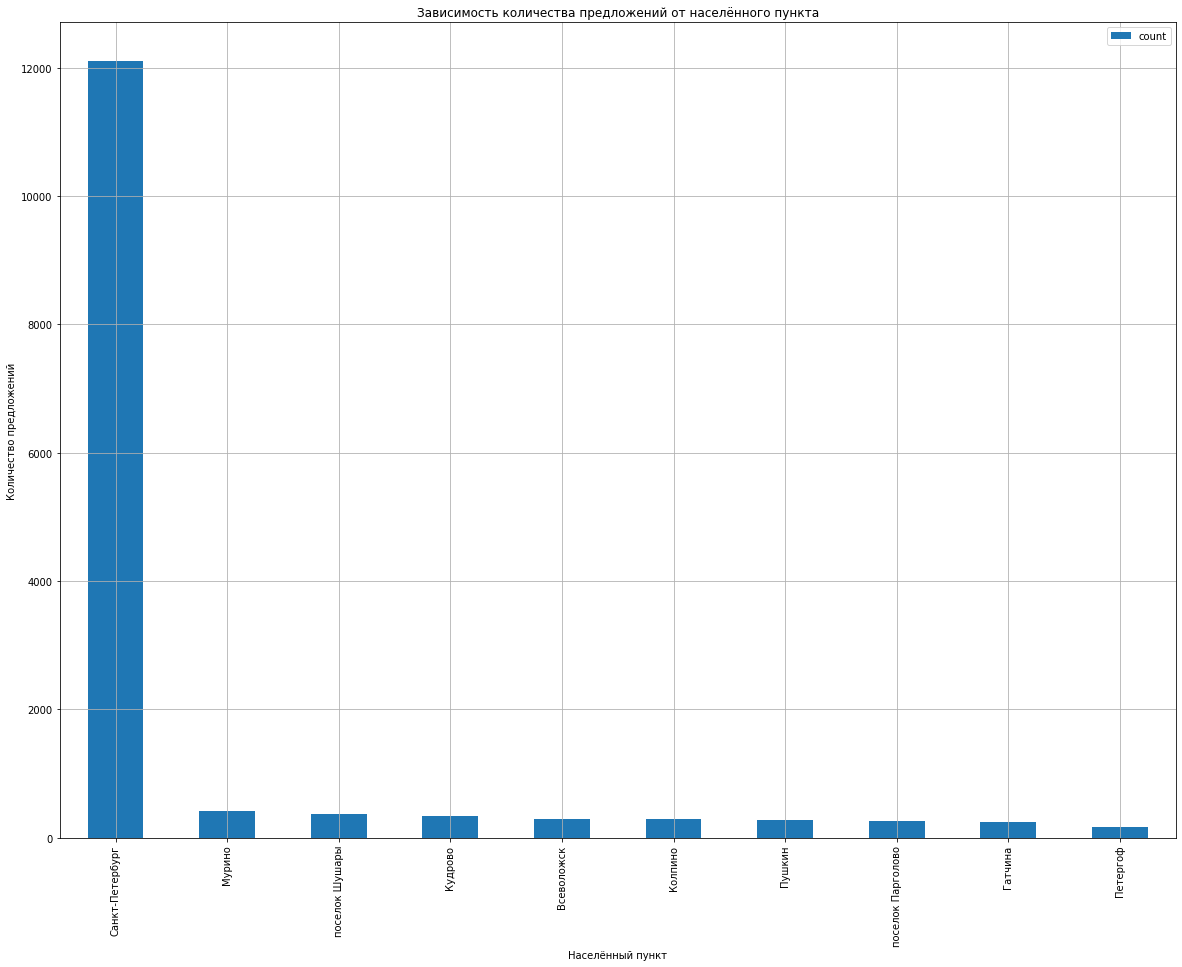

In [90]:
#Воспользуемся сводными таблицами для этой задачи:
locality_pivot_table = data.pivot_table(index='locality_name', values='price_per_sq_m', aggfunc=['count', 'median'])
locality_pivot_table.columns = ['count', 'median']
locality_pivot_table = locality_pivot_table.sort_values('count', ascending=False).head(10)
print(locality_pivot_table)

locality_pivot_table.plot(y='count', kind = 'bar', grid = True, figsize=(20, 15))
plt.title('Зависимость количества предложений от населённого пункта')
plt.ylabel('Количество предложений')
plt.xlabel('Населённый пункт')
plt.show()

Больше всего предложений представлено в Санкт-Петербурге (как неожиданно), замыкает топ-10 Петергоф.

Теперь выведем топ по ценам на квадратный метр:

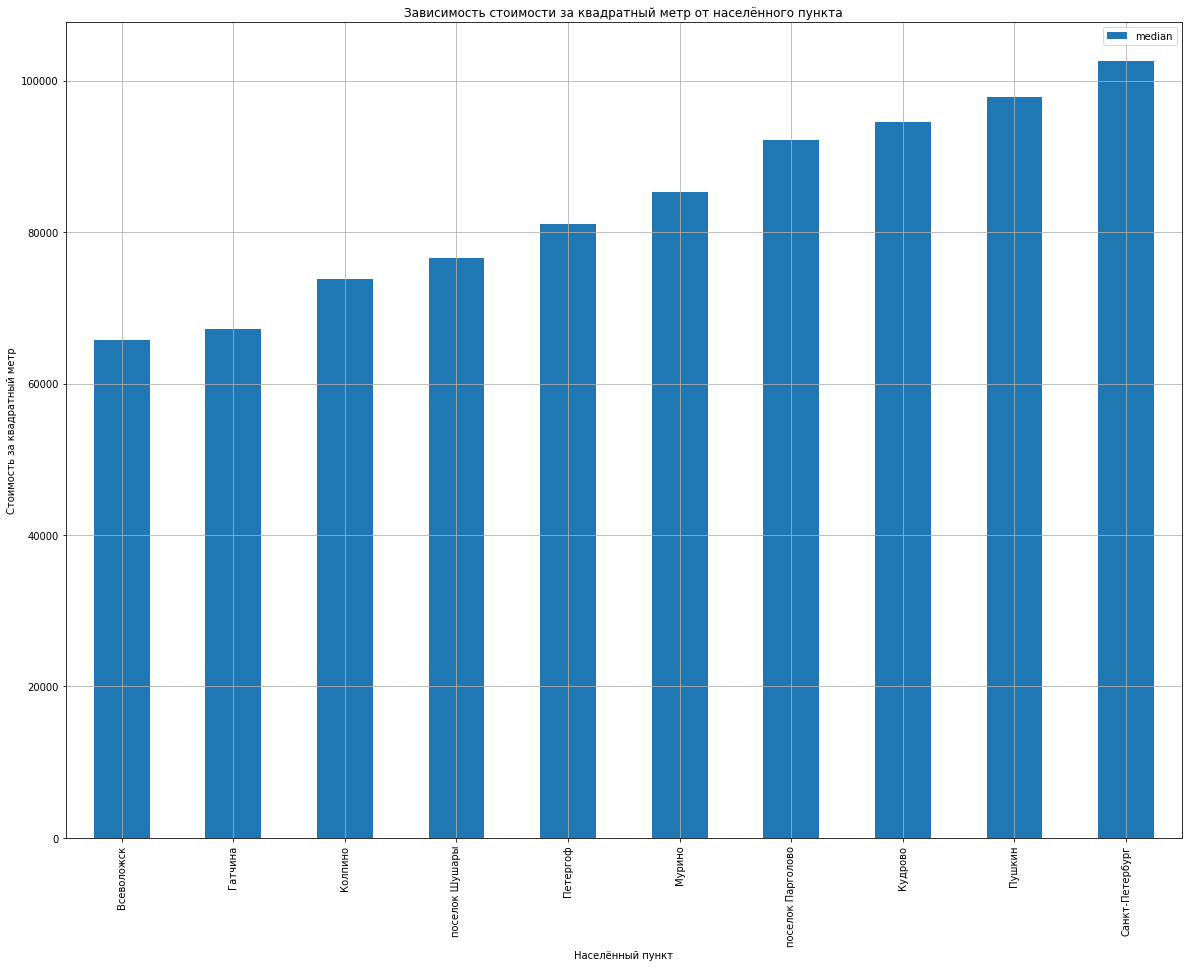

In [91]:
#График по ценам за квадратный метр:
locality_pivot_table.sort_values('median', ascending=True).plot(y='median', kind = 'bar', grid = True, figsize=(20, 15))
plt.title('Зависимость стоимости за квадратный метр от населённого пункта')
plt.ylabel('Стоимость за квадратный метр')
plt.xlabel('Населённый пункт')
plt.show()

Дороже всего ценники в самом Петербурге, однако в целом разброс небольшой. Петергоф, хоть и имеет меньше всего предложений в 10-ке, стоит на 6 месте по стоимости квадратного метра. А вот самым дешёвым оказался Всеволожск.

##### Промежуточный вывод:
Из выведенного топ-10 населённых пунктов по количеству объявлений видим, что чем ближе к Санкт-Петербургу, тем больше предложений; замыкает топ-10 Петергоф. \
По средней цене наблюдается похожая картина - максимальная в Санкт-Петербурге, минимальная во Всеволожске. Распределение по ценам выглядит достаточно линейным.

#### Оценить стоимость квартир в зависимости от удалённости от центра Петербурга

In [92]:
#Для начала представим данные по удалённости от центра в километрах:
data['city_centers_nearest_km'] = data['city_centers_nearest'] / 1000

#Дабы не писать функцию по категоризации каждого километра, изменим тип данных в новом столбце:
data['city_centers_nearest_km'] = data['city_centers_nearest_km'].astype('int')

#Воспользуемся сводными таблицами:
centre_nearest_pivot = data.query('locality_name == "Санкт-Петербург"').pivot_table(
                                                                           index='city_centers_nearest_km', 
                                                                           values='price_per_sq_m', 
                                                                           aggfunc=['count','mean'])
centre_nearest_pivot.columns=['count','mean']
print(centre_nearest_pivot)

                         count           mean
city_centers_nearest_km                      
0                           59  178122.516949
1                          170  152891.120176
2                          221  144069.629502
3                          385  120962.773636
4                          663  132441.802428
5                          548  141851.473047
6                          333  140745.334024
7                          324  142825.147284
8                          499  116941.097074
9                          545  107635.848844
10                         728  109395.175948
11                        1121  104370.119973
12                        1221  106247.199025
13                        1154  106101.448718
14                        1186  102426.541147
15                        1082  100006.804926
16                         879   98349.436815
17                         397   93586.331436
18                         140   94105.907714
19                          70   9

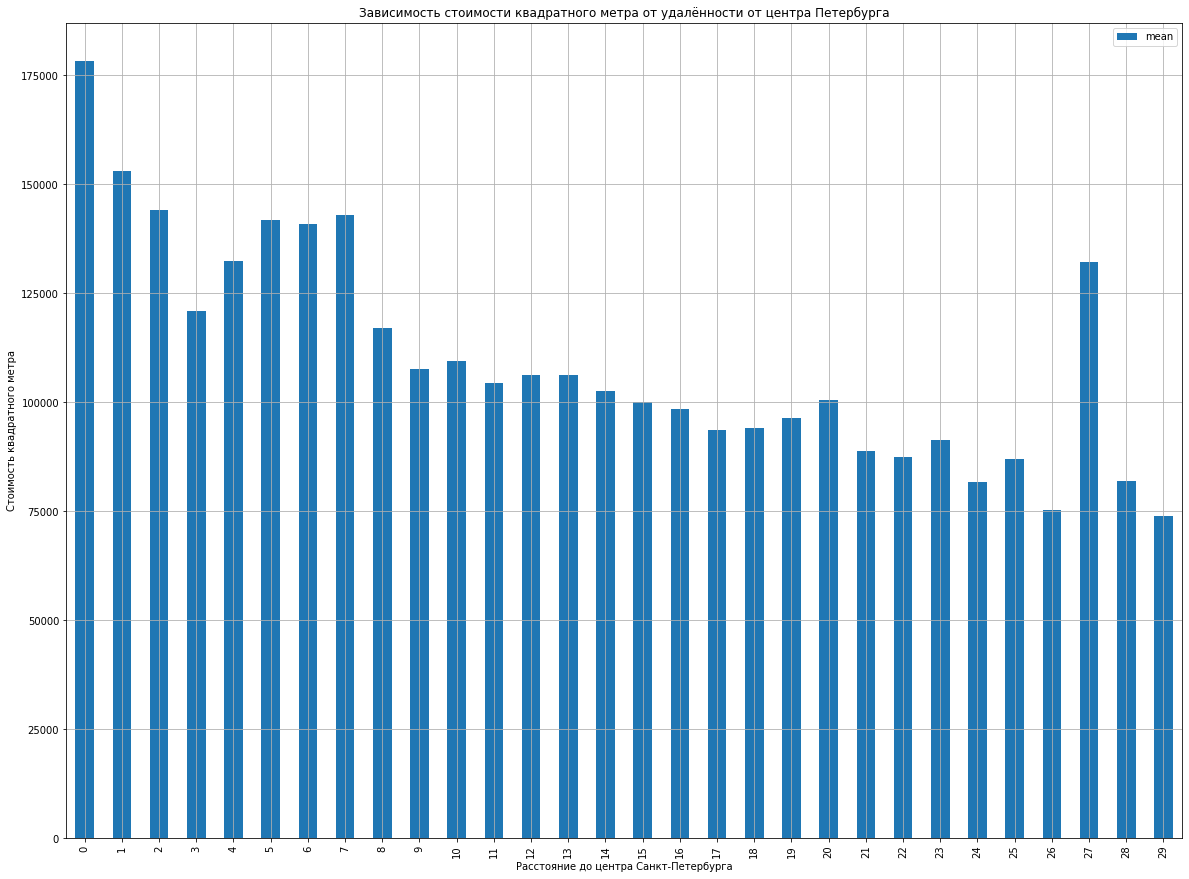

In [93]:
#Построим график для наглядного отображение информации:
centre_nearest_pivot.plot(y='mean', kind='bar', grid=True, figsize=(20,15))
plt.title('Зависимость стоимости квадратного метра от удалённости от центра Петербурга')
plt.ylabel('Стоимость квадратного метра')
plt.xlabel('Расстояние до центра Санкт-Петербурга')
plt.show()

##### Промежуточный вывод:
Судя по графику, есть явная просадка по цене в районе 2-4 км от центра и достаточно высокое значение на 27 км. Просадку можем объяснить тем, что на этом расстоянии от центра ещё осталась пром.зона, а также ж/д вокзалы, людям такое соседство явно не по душе. Подъём характеризует новые районы застройки, некоторые из них действительно стоят внимания.

#### Вывод по разделу:
Произведён исследовательский анализ данных, в ходе которого получены следующие результаты:

Проанализировав все столбцы с количественными переменными можно сказать о том, что конкретные ошибки были допущены в столбце с высотой потолков (были аномально большие и аномально низкие значения, часть из них удалили), а также в столбце с общим количеством этажей (конкретно: дом 60 этажей в Кронштадте и 52 в Санкт-Петербурге, не удаляли, так как особой роли не играют); остальные выбросы не являлись критическими, объяснялись уникальностью продаваемых объектов.\
По гистограммам: у подавляющего большинства вариантов общая площадь варьируется от 20 до 60 квадратных метров; около 85% вариантов были выставлены по цене не превышающей 20 млн рублей; предложений в малоэтажных домах в несколько раз больше; в основном помещения имеют высоту потолков от 2,5 до 2,7 метров; преобладают классические квартиры с 1, 2 или 3 комнатами; объявления о продаже публикуются заметно чаще в будние дни; по общему количесту предложений наблюдался спад к началу лета; предложения по квартирам на первых и последних этажах в доме составляют примерно одинаковую долю по рынку.

В ходе анализа дней размещения объявлений были обнаружены 3 критических аномалии (45, 60 и 90 дней). Предполагаем, что это срок автоматического удаления объявления с площадки по какой-то причине. Чтобы подтвердить данную гипотезу, необходимо обратиться в тех. поддержку сервиса.\
После удаления выбросов получили следующую информацию: среднее время размещения составляет 192 дней, медианное значение - 112; аномально долгим размещением можем считать 570+ дней (Q3 + 1,5IQR), аномально короткое - 1 день.

Проанализировани некоторые факторы, которые в теории могли бы влиять на стоимость квадратного метра помещения, пришли к следующим выводам:

1) Общая площадь является вполне определяет стоимость помещения. С её ростом наблюдается повышение цены, коэффициент корреляции около 0,68;\
2) Жилая площадь реальный фактор, коэффициент корреляции составляет 0,59;\
3) Площадь кухни слабее связана с общей стоимостью, но связь так же является средней возрастающей, коэффициент корреляции 0,5;\
4) Количество комнат влияет на стоимость объекта: чем больше комнат, тем больше цена; зависимость практически линейная;\
5) Тип этажа также достаточно показательный фактор: ценник на квартиры на первых этажах заметно ниже. Людям может не нравится излишняя близость улицы (шум, автомобильные выхлопы и т.д.); \
6) Дата размещения влияет на цену квадратного метра: 
 - по дням недели - наиболее крупные предложения выбрасываются на рынок во вторник, в пятницу и выходные наблюдается спад (это может быть связано с деятельностью риелторских компаний);
 - по месяцам - явный пик приходится на сентябрь и декабрь (предполагаем, что связано с наступление времени, когда можно с комфортом переезжать и делать ремонт), спад наблюдается в июне (все крупные предложения уже были выставлены, присутствует общее желание людей отдыхать, а не заниматься чем-то), в остальное время рынок достаточно стабилен;
 - по годам - крупный спад после событий 14 года, рынок начал снова расти только к 2019 году.

Вывели топ-10 населённых пунктов по количеству объявлений; закономерность: чем ближе к Санкт-Петербургу, тем больше предложений; замыкает топ-10 Петергоф.\
По средней цене наблюдается похожая картина - максимальная в Санкт-Петербурге, минимальная во Всеволожске. Однако распределение более линейно, выбросов и спадов нет.

По графику зависимости цены за квадратный метр от расстояния до центра Петербурга видна явная просадка по цене в районе 2-4 км от центра и достаточно высокое значение на 27 км. Просадку можем объяснить тем, что на этом расстоянии от центра ещё осталась пром.зона, а также ж/д вокзалы; подъём характеризует новые районы застройки.

### Общий вывод

На анализ данных была представлена таблица по недвижимости в Санкт-Петербурге и Ленинградской области за 2014-2019 года. Объекты в таблице были представлены различными жилыми и нежилыми помещениями с различными характеристиками, часть из которых была пропущена, например, высота потолков в помещении.

В ходе предобработки данных пропуски были заменены на медианные значения, чтобы это не отразилось критично на результатах исследования. Часть данных, в которой восстановить пропуски было невозможно, либо же содержались явные выбросы, была удалена. По итогу из начальных 23699 строк пригодными для анализа оказались 17953. Кроме того, были произведены необходимые изменения, касающиеся типов данных, устранены неявные дубликаты в названиях населённых пунктов.

В исходную таблицу были добавлены новые столбцы, необходимые для дальнейшего анализа данных: 
 - цена одного квадратного метра, 
 - день публикации объявления, 
 - месяц публикации объявления,
 - год публикации объявления,
 - тип этажа квартиры,
 - расстояние в км до центра города.

Произведён анализ столбцов с количетсвенными переменными. Конкретные ошибки были допущены в столбце с высотой потолков (были аномально большие и аномально низкие значения, часть из них удалили, часть удалось исправить, поделив исходное значение на 10), а также в столбце с общим количеством этажей (конкретно: дом 60 этажей в Кронштадте и 52 в Санкт-Петербурге); остальные выбросы не являлись критическими, объяснялись уникальностью продаваемых объектов.\
Построены гистограммы, по которым можно сделать следующие выводы: 
 - у подавляющего большинства вариантов общая площадь варьируется от 20 до 60 квадратных метров; 
 - около 85% вариантов были выставлены по цене не превышающей 20 млн рублей; 
 - предложений в малоэтажных домах в несколько раз больше; 
 - в основном помещения имеют высоту потолков от 2,5 до 2,7 метров; 
 - преобладают классические квартиры с 1, 2 или 3 комнатами; 
 - объявления о продаже публикуются заметно чаще в будние дни; 
 - по общему количесту предложений наблюдался спад в начале лета; 
 - предложения по квартирам на первых и последних этажах в доме составляют примерно одинаковую долю по рынку.
 
#### Выполнено задание по изучению продолжительности размещения объявления:
В ходе анализа дней размещения объявлений были обнаружены 3 критических аномалии (45, 60 и 90 дней). Предполагаем, что это срок автоматического удаления объявления с площадки по какой-то причине. Чтобы подтвердить данную гипотезу, необходимо обратиться в тех. поддержку сервиса.\
После удаления выбросов получили следующую информацию: среднее время размещения составляет 192 дней, медианное значение - 112; аномально долгим размещением можем считать 570+ дней (Q3 + 1,5IQR), аномально короткое - 1 день.

#### Выполнено задание по анализу факторов, влияющих на стоимость квадратного метра помещения:
Проанализировани некоторые факторы, которые в теории могли бы влиять на стоимость квадратного метра помещения, пришли к следующим выводам:

1) Общая площадь является вполне определяет стоимость помещения. С её ростом наблюдается повышение цены, коэффициент корреляции около 0,68;\
2) Жилая площадь реальный фактор, коэффициент корреляции составляет 0,59;\
3) Площадь кухни слабее связана с общей стоимостью, но связь так же является средней возрастающей, коэффициент корреляции 0,5;\
4) Количество комнат влияет на стоимость объекта: чем больше комнат, тем больше цена; зависимость практически линейная;\
5) Тип этажа также достаточно показательный фактор: ценник на квартиры на первых этажах заметно ниже. Людям может не нравится излишняя близость улицы (шум, автомобильные выхлопы и т.д.); \
6) Дата размещения влияет на цену квадратного метра: 
 - по дням недели - наиболее крупные предложения выбрасываются на рынок во вторник, в пятницу и выходные наблюдается спад (это может быть связано с деятельностью риелторских компаний);
 - по месяцам - явный пик приходится на сентябрь и декабрь (предполагаем, что связано с наступление времени, когда можно с комфортом переезжать и делать ремонт), спад наблюдается в июне (все крупные предложения уже были выставлены, присутствует общее желание людей отдыхать, а не заниматься чем-то), в остальное время рынок достаточно стабилен;
 - по годам - крупный спад после событий 14 года, рынок начал снова расти только к 2019 году.

#### Выполнено задание по составлению топ-10 населённых пунктов по количеству предложений и стоимости жилья:
Вывели топ-10 населённых пунктов по количеству объявлений; закономерность: чем ближе к Санкт-Петербургу, тем больше предложений; замыкает топ-10 Петергоф.\
По средней цене наблюдается похожая картина - максимальная в Санкт-Петербурге, минимальная во Всеволожске. Однако распределение более линейно, выбросов и спадов нет.

#### Выполнено задание по подсчёту стоимости каждого километра в зависимотси от удаления от центра Санкт-Петербурга:
По графику зависимости цены за квадратный метр от расстояния до центра Петербурга видна явная просадка по цене в районе 2-4 км от центра и достаточно высокое значение на 27 км. Просадку можем объяснить тем, что на этом расстоянии от центра ещё осталась пром.зона, а также ж/д вокзалы; подъём характеризует новые районы застройки.

#### Итог:
В ходе анализа данных все поставленные задачи были выполнены: построены информативные графики зависимости величин друг от друга и необходимые гистограммы, получены конкретные результаты по каждому пункту. Обработанных данных оказалось достаточно для анализа, дополнительных исследований не требуется.